# Imports

In [1]:
# !pip install PyMuPDF 
# !pip install transformers torch
# !pip install --upgrade ipywidgets
# !pip install -U gensim

In [25]:
import fitz  # PyMuPDF
import torch
import logging
import spacy
import os
import string
import warnings
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, OneHotEncoder, StandardScaler
from scipy.sparse import hstack, csr_matrix
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel, TFAutoModel
from collections import Counter, defaultdict
from gensim.models import Word2Vec

# Loading Data

In [26]:
df = pd.read_csv('pre-processed data.csv').set_index(['article_id' , 'paragraph_id'], inplace=False)
df['pos_tags'] = df['pos_tags'].apply(ast.literal_eval)
df

text  \
article_id paragraph_id                                                      
1          1             provincie willen slag versoepeling stikstofreg...   
           2             draaien allemaal drempelwaran stikstofvergunni...   
           3             hoog drempelwaard vergunning [NEWLINE] aangevo...   
           4             hoofdlijnenakkoord vier coalitiepartij afsprek...   
           5             ondergren lang onderwerp discussie huidig Nede...   
...                                                                    ...   
104        2             telgenkamp vestigen hoop kort termijn twee cru...   
105        1             verzekeraar inkomst zwart werk vergoeden [NEWL...   
106        1             verzekeraar klant helpen zorgbemiddeling [NEWL...   
           2             verzekeraar wachten patiënt snel zorg helpen [...   
           3             zorgbemiddeling wondermiddel helpen zeggen Haa...   

                                   group publication_date  \
article_id paragraph_id                                     
1          1             Bouw & Vastgoed       2024-08-28   
           2             Bouw & Vastgoed       2024-08-28   
           3             Bouw & Vastgoed       2024-08-28   
           4             Bouw & Vastgoed       2024-08-28   
           5             Bouw & Vastgoed       2024-08-28   
...                                  ...              ...   
104        2                        Zorg       2024-10-08   
105        1                        Zorg       2024-10-17   
106        1                        Zorg       2024-10-16   
           2                        Zorg       2024-10-16   
           3                        Zorg       2024-10-16   

                                                      file_path  \
article_id paragraph_id                                           
1          1             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           2             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           3             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           4             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
           5             data\Bouw & Vastgoed\1, 28-08-2024.pdf   
...                                                         ...   
104        2                        data\Zorg\7, 08-10-2024.pdf   
105        1                        data\Zorg\8, 17-10-2024.pdf   
106        1                        data\Zorg\9, 16-10-2024.pdf   
           2                        data\Zorg\9, 16-10-2024.pdf   
           3                        data\Zorg\9, 16-10-2024.pdf   

                                                             original_text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
104        2             Telgenkamp vestigt haar hoop voor de korte ter...   
105        1             Waarom verzekeraars inkomsten uit zwart werk w...   
106        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             provincies willen slag versoepeling stikstofre...   
           2             draait allemaal drempelwaarde stikstofvergunni...   
           3             hogere drempelwaarde vergunningen [NE

In [27]:
for group in df['group'].unique():
    print(f"{len(df[df['group'] == group])} paragraphs in {group}.")

106 paragraphs in Bouw & Vastgoed.
101 paragraphs in Handel & Industrie.
71 paragraphs in Zakelijke Dienstverlening.
48 paragraphs in Zorg.


In [28]:
#Try SMOTE and oversampling to balance the data when testing for 2025 data

# Data Splitting

We define a function to split the data over a training-, validation- and test set. <br>
It is important to ensure that all paragraphs of an article must be assigned to the same set to avoid data leakage. <br>
However, since not all articles contain the same number of paragraphs, splitting the data into 3 sets with pre-defined ratios presents a challenge. <br>
To handle this, an incremental solution will be implemented to ensure that we remain close to the pre-defined ratios of the sets.

In [29]:
def split_dataframe_by_articles(df, val_ratio=0.15, test_ratio=0.15, stratify=None, random_seed=53309):

    """
    Splits a multi-index pandas DataFrame (article_id, paragraph_id) into training, validation, and test sets 
    while ensuring that all paragraphs from the same article remain in the same set.

    Parameters:
    - df (pd.DataFrame): DataFrame with the tuple (article_id, paragraph_id) as its multi-index.
    - val_ratio (float): Proportion of data for validation.
    - test_ratio (float): Proportion of data for testing.
    - stratify (str or None): Column name to stratify by at the article level. Defaults to "group" if it exists in df, otherwise None.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - df_train, df_val, df_test (pd.DataFrame): Split DataFrames
    """
    if not (isinstance(val_ratio, float) and isinstance(test_ratio, float)):
        raise ValueError(f"Invalid input types")
    if not (test_ratio + val_ratio < 1.0):
        raise ValueError(f"Invalid input values")
    
    train_ratio = 1.0 - (val_ratio + test_ratio)

    np.random.seed(random_seed)

    # Set default stratify column if not provided
    if stratify is None and "group" in df.columns:
        stratify = "group"

    # Get unique article IDs
    article_ids = df.index.get_level_values(0).unique()

    # If stratify is provided, group article IDs by stratification column
    if stratify and stratify in df.columns:
        stratify_values = df.groupby(level=0)[stratify].first()  # Get the stratify column per article
        stratified_groups = defaultdict(list)
        
        for article_id, value in stratify_values.items():
            stratified_groups[value].append(article_id)
        
        train_ids, val_ids, test_ids = [], [], []

        # Stratify within each group
        for group in stratified_groups.values():
            np.random.shuffle(group)  # Shuffle within the stratification group
            total_articles = len(group)
            
            train_end = round(train_ratio * total_articles)
            val_end = train_end + round(val_ratio * total_articles)

            train_ids.extend(group[:train_end])
            val_ids.extend(group[train_end:val_end])
            test_ids.extend(group[val_end:])
    
    else:
        # Random split without stratification
        shuffled_ids = np.random.permutation(article_ids)

        total_articles = len(shuffled_ids)
        train_end = round(train_ratio * total_articles)
        val_end = train_end + round(val_ratio * total_articles)

        train_ids, val_ids, test_ids = (
            shuffled_ids[:train_end], 
            shuffled_ids[train_end:val_end], 
            shuffled_ids[val_end:]
        )

    # Assign data to splits
    df_train = df.loc[train_ids]
    df_val = df.loc[val_ids]
    df_test = df.loc[test_ids]

    return df_train, df_val, df_test

In [30]:
test1, test2, test3 = split_dataframe_by_articles(df)
total = len(test1) + len(test2) + len(test3)

print("Lengths & Ratios:")
print(len(test1), len(test2), len(test3))
print(len(test1) / total, len(test2) / total, len(test3) / total)

Lengths & Ratios:
236 50 40
0.7239263803680982 0.15337423312883436 0.12269938650306748


As we can see, we roughly achieve the pre-defined ratios

In [31]:
def check_label_distribution(df_train, df_val, df_test, label_col="group"):
    """
    Prints the percentage distribution of labels in train, validation, and test sets.
    
    Parameters:
    - df_train (pd.DataFrame): Training set
    - df_val (pd.DataFrame): Validation set
    - df_test (pd.DataFrame): Test set
    - label_col (str): Column name representing labels
    """
    def compute_distribution(df, label_col):
        return df[label_col].value_counts(normalize=True) * 100  # Convert to percentage

    print("Label Distribution in Training Set:")
    print(compute_distribution(df_train, label_col))
    print("\nLabel Distribution in Validation Set:")
    print(compute_distribution(df_val, label_col))
    print("\nLabel Distribution in Test Set:")
    print(compute_distribution(df_test, label_col))

check_label_distribution(test1, test2, test3)

Label Distribution in Training Set:
Bouw & Vastgoed              30.932203
Handel & Industrie           28.389831
Zakelijke Dienstverlening    23.728814
Zorg                         16.949153
Name: group, dtype: float64

Label Distribution in Validation Set:
Handel & Industrie           42.0
Bouw & Vastgoed              36.0
Zakelijke Dienstverlening    14.0
Zorg                          8.0
Name: group, dtype: float64

Label Distribution in Test Set:
Bouw & Vastgoed              37.5
Handel & Industrie           32.5
Zakelijke Dienstverlening    20.0
Zorg                         10.0
Name: group, dtype: float64


As we can see, the data has been stratified so that the class distribution is roughly equal in the 3 sets.

# Overarching Function

**The function evaluate_model() as described below is an overarching function for finding the model with the highest validation accuracy given the provided parameter values.** <br>

Expected parameter values: <br>
- **df**: Pandas DataFrame containing the following columns:
> **original_text**: Text before any pre-processing steps were taken, $str$ <br>
> **text before lemmatization**: Text just before lemmatization has taken place, $str$ <br>
> **text**: Text after all pre-processing steps have been completed, $str$ <br>
> **pos_tags**: Part-Of-Speech tags, $list$ <br>
> **group**: Target variable, $str$ (Converted to numeric in the evaluate_model function) <br>
- **test_ratio**: The ratio of the data that is reserved for testing. Any floating point in the inclusive interval [0, 1].
> Note that in the case of hold-out cross-validation (which is performed when $k=1$), test_ratio is also used the ratio of training data that is reserved for validation.
- **k_values**: List of k values for k-fold cross-validation. Default value: [2, 3, 5, 10, 20]
- **model_type**: Selects the type of classifier from amongst the following: ["svm", "naive_bayes", "random_forest"].
> If model_type="naive_bayes", a multinomial naive bayes classifier is trained if $pos=$"none" and embedding $\in$ ["BoW", "tf-idf"]. Otherwise, a Gaussian naive bayes classifier is trained since the resulting word embedding will contain continuous features, which multinomial naive bayes classifiers cannot handle.
- **embedding**: Selects the type of word embedding from amongst the following: ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"].
- **pos**: Selects how POS tags are used from amongst the following: ["none", "one-hot", "ngram"].
- **ngram_size**: Selects the type of ngrams that are used. Must be an integer, no smaller than 2. Set to 2 by default.
> Note that if _pos_$\neq$"ngram", n is not used and the value of ngram_size is irrelevant.
- **print_updates**: If set to True, intermediate and final results will be printed in addition to being returned. Default value: True
- **show_class_accuracy**: If set to True, the accuracies per class are shown for the final classifier. Default: True
- **show_confusion_matrix**: If set to True, the resulting confusion matrix of the final classifier will be shown. Default: True
- **return_data**: If set to True, the function returns not only results and best_model, but also the data used to train, validate and test the model
- **save_first_vectorizer**: If True, return first vectorizer as well. Works only for tf-idf.

**The parameters below are model-specific and their values are only relevant if the corresponding model type is selected.**

- **C_values**: A list containing all values of C to be tested for SVM classifiers. Default value: [0.1, 1, 10]
- **kernel_values**: A list containing all kernel types to be tested for SVM classifiers. Default value: ['linear', 'rbf', 'poly']
- **max_depth_values**: A list containing all maximum depth values to be tested for Random Forest classifiers. Default value: [5, 10, 15, 20, None]
- **alpha_values**: A list containing all $\alpha$ values to be tested for multinomial naive bayes classifiers. Default value: [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
- **fit_prior_values**: A list containing all prior_values values to be tested for Multinomial Naive Bayes classifiers. Default value: [True, False]
- **var_smoothing_values**: A list containing all var_smoothing values to be tested for Gaussian Naive Bayes classifiers. Default value: [$10^{-11}$, $10^{-10}$, $10^{-9}$, $10^{-8}$, $10^{-7}$]

In [32]:
def evaluate_model(df: pd.DataFrame, test_ratio: float = 0.15, k_values: list = [2, 3, 5, 10, 20], 
                   model_type: str = "svm", embedding: str = "tf-idf",
                   pos: str = "none", ngram_size: int = 2, print_updates: bool = True,
                   show_class_accuracy: bool = True, show_confusion_matrix: bool = True, 
                   return_data = False, save_first_vectorizer = False,
                   C_values: list = [0.1, 1, 10], kernel_values: list = ['linear', 'rbf', 'poly'],
                   max_depth_values: list = [5, 10, 15, 20, None],
                   alpha_values: list = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values: list = [True, False],
                   var_smoothing_values: list = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7]):
    """
    Function to extract embeddings (TF-IDF or BERTje), perform classification with SVM hyperparameter tuning, and evaluate using k-fold cross-validation.

    For parameters, see the markdown above this cell.

    Returns:
        dict: Dictionary of accuracies for each k and best SVM hyperparameters.
    """
    
    #Raise appropriate error message in case of a faulty parameter value
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Invalid input data. Please ensure df is a Pandas DataFrame")
    if test_ratio <= 0 or test_ratio >= 1:
        raise ValueError(f"Invalid test_ratio. Choose a value in the exclusive interval (0,1)")
    if not all(isinstance(x, int) and x > 0 for x in k_values):
        raise ValueError(f"Invalid k_values. Please ensure all entries in k_values are positive integers")
    if model_type.lower() not in ["svm", "naive_bayes", "random_forest"]:
        raise ValueError(f"Invalid model_type. Choose from {'SVM', 'Naive_Bayes', 'Random_Forest'}")
    if embedding.lower() not in ["bow", "tf-idf", "bertje", "mbert", "robbert", "word2vec"]:
        raise ValueError(f'Invalid embedding. Choose from ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]')
    if pos not in ["none", "one-hot", "ngram"]:
        raise ValueError(f'Invalid pos. Choose from ["none", "one-hot", "ngram"]')
    if type(ngram_size) != int or ngram_size < 2:
        raise ValueError(f'Invalid ngram_size. Please ensure that ngram_size is an integer, no smaller than 2')
    if not type(print_updates) == bool:
        raise ValueError(f'Invalid print_updates value. Please ensure this parameter has a boolean value.')
    if not isinstance(show_class_accuracy, bool):
        raise ValueError(f'Invalid show_class_accuracy value. Please ensure this parameter has a boolean value.')
    if not isinstance(show_confusion_matrix, bool):
        raise ValueError(f'Invalid show_confusion_matrix value. Please ensure this parameter has a boolean value.')
    if not isinstance(return_data, bool):
        raise ValueError(f'Invalid return_data value. Please ensure this parameter has a boolean value.')
    if not all(x > 0 for x in C_values):
        raise ValueError(f'Invalid C_values. Please ensure that all entries in C_values lie in the exclusive interval (0, inf)')
    if not all(type(x) == str for x in kernel_values):
        raise ValueError(f'Invalid kernel_values. Please ensure every entry in kernel_values is a string that represents a kernel type')
    if not all((type(x) == int and x > 0) or x == None for x in max_depth_values):
        raise ValueError(f'Invalid max_depth_values. Please ensure every entry in max_depth_values is a positive integer or None for no maximum')
    if not all((type(x) == int or type(x) == float) and (x > 0) for x in alpha_values):
        raise ValueError(f'Invalid alpha_values. Please ensure every entry in alpha_values is numeric and non-negative')
    if not all(type(x) == bool for x in fit_prior_values):
        raise ValueError(f'Invalid fit_prior_values. Please ensure every entry in fit_prior_values is boolean')
    if not all(x >= 0 for x in var_smoothing_values):
        raise ValueError(f'Invalid var_smoothing_values. Please ensure every entry in var_smoothing_values is a non-negative number')

    first_iteration = True

    # Convert labels to numeric format
    df["label"] = df["group"].astype("category").cat.codes 
    df_train, df_val, df_test = split_dataframe_by_articles(df, val_ratio=test_ratio, test_ratio=test_ratio, stratify="label")
    
    # ===========================
    # 1. Extract Features (BoW, TF-IDF, BERTje, mBERT, RobBERT or Word2Vec)
    # ===========================

    if embedding.lower() == "bow":
        if print_updates:
            print("\nUsing Bag of Words (BoW) Embeddings...")
        vectorizer = CountVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        val_embeddings = vectorizer.transform(df_val["text"])#.toarray()
        test_embeddings = vectorizer.transform(df_test["text"])#.toarray()
    
    elif embedding.lower() == "tf-idf":
        if print_updates:
            print("\nUsing TF-IDF Embeddings...")
        vectorizer = TfidfVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        val_embeddings = vectorizer.transform(df_val["text"])
        test_embeddings = vectorizer.transform(df_test["text"])
        if save_first_vectorizer and first_iteration:
            vectorizer_backup = vectorizer
            first_iteration = False

    elif embedding.lower() in ["bertje", "mbert", "robbert"]:
        if embedding.lower() == "bertje":
            model_name = "GroNLP/bert-base-dutch-cased"
        elif embedding.lower() == "mbert":
            model_name = "bert-base-multilingual-cased"
        elif embedding.lower() == "robbert":
            model_name = "pdelobelle/robbert-v2-dutch-base"

        if print_updates:
            print(f"\nUsing {embedding.upper()} Embeddings ({model_name})...")

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()

        def get_word_embedding(text):
            with torch.no_grad():
                tokens = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
                output = model(**tokens)
                embeddings = output.last_hidden_state.mean(dim=1)
            return embeddings.squeeze().numpy()

        if print_updates:
            print(f"\nCreating {embedding} embedding, this may take a few minutes.")
        embeddings = np.array([get_word_embedding(text) for text in df_train["text"]])
        val_embeddings = np.array([get_word_embedding(text) for text in df_val["text"]])
        test_embeddings = np.array([get_word_embedding(text) for text in df_test["text"]])

    elif embedding.lower() == "word2vec":
        if print_updates:
            print("\nUsing Word2Vec Embeddings...")

        sentences = [text.split() for text in df_train["text"]]
        w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)

        def get_w2v_embedding(text):
            words = text.split()
            word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
            return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)

        embeddings = np.array([get_w2v_embedding(text) for text in df_train["text"]])
        val_embeddings = np.array([get_w2v_embedding(text) for text in df_val["text"]])
        test_embeddings = np.array([get_w2v_embedding(text) for text in df_test["text"]])

    else:
        raise ValueError("Invalid embedding type. Choose 'tf-idf' 'BERTje', 'mBERT', 'RobBERT' or 'Word2Vec'.")

    # ===========================
    # 2. Process POS Tags if Needed
    # ===========================

    if pos == "one-hot":
        if print_updates:
            print("\nUsing One-Hot Encoding for POS Tags...")

        def pos_to_features(pos_tags):
            """Convert list of (word, POS) tuples into a dictionary of POS tag counts."""
            pos_counts = Counter(tag for _, tag in pos_tags)
            return dict(pos_counts)

        # Convert to list of dictionaries
        pos_features = [pos_to_features(tags) for tags in df_train["pos_tags"]]
        val_pos_features = [pos_to_features(tags) for tags in df_val["pos_tags"]]
        test_pos_features = [pos_to_features(tags) for tags in df_test["pos_tags"]]
    
        # Convert list of dictionaries to Pandas DataFrame (fill missing tags with 0)
        pos_df = pd.DataFrame(pos_features).fillna(0)
        pos_df_val = pd.DataFrame(val_pos_features).fillna(0)
        pos_df_test = pd.DataFrame(test_pos_features).fillna(0)

        # Ensure that pos_df_test and pos_df_test have the same columns
        pos_df_val = pos_df_val.reindex(columns=pos_df.columns, fill_value=0)
        pos_df_test = pos_df_test.reindex(columns=pos_df.columns, fill_value=0)
    
        # Create OneHotEncoder and use it on the pos features
        encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
        pos_features_encoded = encoder.fit_transform(pos_df)
        pos_features_encoded_val = encoder.transform(pos_df_val)
        pos_features_encoded_test = encoder.transform(pos_df_test)
    
        # Scale the POS features
        scaler = StandardScaler()
        pos_features_scaled = scaler.fit_transform(pos_features_encoded)
        pos_features_scaled_val = scaler.transform(pos_features_encoded_val)
        pos_features_scaled_test = scaler.transform(pos_features_encoded_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(val_embeddings, np.ndarray):  
            val_embeddings = csr_matrix(val_embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_features_scaled, csr_matrix):  
            pos_features_scaled = csr_matrix(pos_features_scaled)  # Convert dense to sparse
        if not isinstance(pos_features_scaled_val, csr_matrix):  
            pos_features_scaled_val = csr_matrix(pos_features_scaled_val)  # Convert dense to sparse
        if not isinstance(pos_features_scaled_test, csr_matrix):  
            pos_features_scaled_test = csr_matrix(pos_features_scaled_test)  # Convert dense to sparse

        # Combine embeddings with POS features
        embeddings = hstack([embeddings, pos_features_scaled])
        val_embeddings = hstack([val_embeddings, pos_features_scaled_val])
        test_embeddings = hstack([test_embeddings, pos_features_scaled_test])

    elif pos.lower() == "ngram":
        if print_updates:
            print(f"\nUsing N-gram POS Features (n={ngram_size})...")
        
        # Function to convert POS tags to n-grams
        def pos_to_ngrams(pos_tags, n=2):
            """Convert a list of POS-tag tuples into n-gram strings."""
            pos_sequence = [tag for _, tag in pos_tags]  # Extract only POS tags
            ngrams = ['_'.join(pos_sequence[i:i+n]) for i in range(len(pos_sequence)-n+1)]
            return ' '.join(ngrams)  # Convert to space-separated string for TF-IDF

        # Create POS n-grams
        pos_ngrams = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_train["pos_tags"]])
        pos_ngrams_val = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_val["pos_tags"]])
        pos_ngrams_test = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_test["pos_tags"]])

        # Use TF-IDF to extract n-gram features
        vectorizer = TfidfVectorizer(max_features=1000)  # Use fewer features since it's for POS
        pos_embeddings = vectorizer.fit_transform(pos_ngrams)#.toarray()
        pos_embeddings_val = vectorizer.transform(pos_ngrams_val)
        pos_embeddings_test = vectorizer.transform(pos_ngrams_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(val_embeddings, np.ndarray):  
            val_embeddings = csr_matrix(val_embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_embeddings, csr_matrix):  
            pos_embeddings = csr_matrix(pos_embeddings)  # Convert dense to sparse
        if not isinstance(pos_embeddings_val, csr_matrix):  
            pos_embeddings_val = csr_matrix(pos_embeddings_val)  # Convert dense to sparse
        if not isinstance(pos_embeddings_test, csr_matrix):  
            pos_embeddings_test = csr_matrix(pos_embeddings_test)  # Convert dense to sparse
        
        # Combine embeddings with POS n-grams features
        embeddings = hstack([embeddings, pos_embeddings])
        val_embeddings = hstack([val_embeddings, pos_embeddings_val])
        test_embeddings = hstack([test_embeddings, pos_embeddings_test])

    elif pos != "none":
        raise ValueError("Invalid POS type. Choose 'none', 'one-hot', or 'ngram'.")

    # ===========================
    # 3. Model Evaluation (Holdout or k-Fold) with Hyperparameter Search
    # ===========================

    # Set initial performance metrics such that they can be updated after a better classifier has been found
    # best_k = None
    best_accuracy = 0
    best_params = None
    results = {}
    best_functionwide_accuracy = 0
    best_functionwide_params = None

    # For every value of k, we find the best parameter settings and save them in the results dictionary
    for k in k_values:
        param_results = {}
        # accuracy_scores = []
        # best_model_params = {}

        if k == 1: # Use regular hold-out cross-validation
            X_train, X_val, y_train, y_val = embeddings, val_embeddings, df_train["label"], df_val["label"]
            
            if model_type.lower() == "svm":
                for C in C_values:
                    for kernel in kernel_values:
                        classifier = SVC(kernel=kernel, C=C)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        param_results.setdefault((C, kernel), []).append(accuracy)
            
            elif model_type.lower() == "random_forest":
                for max_depth in max_depth_values:
                    classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                    classifier.fit(X_train, y_train)
                    accuracy = accuracy_score(y_val, classifier.predict(X_val))
                    param_results.setdefault((max_depth), []).append(accuracy)
            
            elif model_type.lower() == "naive_bayes":
                if pos == "none" and embedding.lower() in ["bow", "tf-idf"]: # In this case all features are discrete, so we can use MultinomialNB
                    for alpha in alpha_values:
                        for fit_prior in fit_prior_values:
                            classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            param_results.setdefault((alpha, fit_prior), []).append(accuracy)
                else: # In this case, there are continuous features, so we use GaussianNB
                    for var_smoothing in var_smoothing_values:
                        classifier = GaussianNB(var_smoothing=var_smoothing)
                        
                        if isinstance(X_train, np.ndarray):
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        else:
                            classifier.fit(X_train.toarray(), y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                            
                        param_results.setdefault((var_smoothing), []).append(accuracy)

            else:
                raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')

            # accuracy_scores.append(best_accuracy)
            
        else:  # Use stratified k-fold cross-validation
            X_val = val_embeddings
            y_val = df_val["label"]
            kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
            # for train_index, val_index in kf.split(embeddings, df_train["label"]):
            for fold, (train_index, val_index) in enumerate(kf.split(embeddings, df_train["label"])):
                X_train = embeddings[train_index]
                y_train = df_train["label"].iloc[train_index].values
                
                best_fold_accuracy = 0
                
                if model_type == "svm":
                    for C in C_values:
                        for kernel in kernel_values:
                            classifier = SVC(kernel=kernel, C=C)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            param_results.setdefault((C, kernel), []).append(accuracy)
                
                elif model_type == "random_forest":
                    for max_depth in max_depth_values:
                        classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        param_results.setdefault((max_depth), []).append(accuracy)
                
                elif model_type == "naive_bayes":
                    if pos == "none" and embedding.lower() in ["bow", "tf-idf"]:
                        for alpha in alpha_values:
                            for fit_prior in fit_prior_values:
                                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                                classifier.fit(X_train, y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val))
                                param_results.setdefault((alpha, fit_prior), []).append(accuracy)
                    else:
                        for var_smoothing in var_smoothing_values:
                            classifier = GaussianNB(var_smoothing=var_smoothing)
                            if isinstance(X_train, np.ndarray):
                                classifier.fit(X_train, y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            else:
                                classifier.fit(X_train.toarray(), y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                            param_results.setdefault((var_smoothing), []).append(accuracy)
                                
                else:
                    raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')
                
                # accuracy_scores.append(best_fold_accuracy)
        
        # results[k] = {"accuracy": np.mean(accuracy_scores), "best_params": best_model_params}

        # Compute mean accuracy for each hyperparameter set
        mean_accuracies = {params: np.mean(acc_list) for params, acc_list in param_results.items()}
        best_params = max(mean_accuracies, key=mean_accuracies.get)
        best_accuracy = mean_accuracies[best_params]
        results[k] = {"accuracy": best_accuracy, "best_params": best_params}
        
        if print_updates:
            print(f"Best {model_type} Params for k={k}: {results[k]['best_params']}, Mean Validation Accuracy: {results[k]['accuracy']:.4f}")
        
        if print_updates:
            print(f"param_results: {param_results}")
            print(f"mean results: {mean_accuracies}")
            print(f"best validation accuracy for K={k}: {best_accuracy}")
            print(f"best functionwide validation accuracy: {best_functionwide_accuracy}\n")

        # Train final model on full training set if this is the best performance so far
        if best_accuracy > best_functionwide_accuracy:
            best_functionwide_accuracy = best_accuracy
            best_functionwide_params = best_params
            if not isinstance(best_params, tuple):
                best_params = (best_params,)
            if model_type.lower() == "svm":
                best_model = SVC(C=best_params[0], kernel=best_params[1])
            elif model_type.lower() == "random_forest":
                best_model = RandomForestClassifier(max_depth=best_params[0], random_state=42)
            elif model_type.lower() == "naive_bayes":
                if pos == "none" and embedding.lower() in ["bow", "tf-idf"]:
                    best_model = MultinomialNB(alpha=best_params[0], fit_prior=best_params[1])
                else:
                    best_model = GaussianNB(var_smoothing=best_params[0])
                    
            if isinstance(X_train, np.ndarray):
                best_model.fit(X_train, y_train)
            else:
                best_model.fit(X_train.toarray(), y_train)
    
    # Evaluate best model on test set
    if not isinstance(test_embeddings, np.ndarray):
        test_accuracy = accuracy_score(df_test["label"], best_model.predict(test_embeddings.toarray()))
    else:
        test_accuracy = accuracy_score(df_test["label"], best_model.predict(test_embeddings))
        
    if print_updates:
        print(f"\nBest model found: \nModel={model_type}, \nParameter values: {best_params}, \nValidation Accuracy: {best_functionwide_accuracy:.4f}")
        print(f"Final Test Accuracy: {test_accuracy:.4f}")

    if show_class_accuracy:
        y_test = df_test["label"]
        
        if not isinstance(test_embeddings, np.ndarray):
            y_pred = best_model.predict(test_embeddings.toarray())
        else:
            y_pred = best_model.predict(test_embeddings)
            
        cm = confusion_matrix(y_test, y_pred)
        
        # Class names (assuming they are in the same order as in y_train or y_test)
        class_names = np.unique(y_test)  # This will give you the unique class labels
        
        # Calculate per-class accuracy: TP / (TP + FN)
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        
        # Print the accuracy for each class along with its name
        for i, acc in enumerate(class_accuracies):
            print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

    if show_confusion_matrix:
        y_test = df_test["label"]
        
        if not isinstance(test_embeddings, np.ndarray):
            y_pred = best_model.predict(test_embeddings.toarray())
        else:
            y_pred = best_model.predict(test_embeddings)
            
        cm = confusion_matrix(y_test, y_pred)
        class_mapping = {0: 'Bouw & Vastgoed', 1: 'Handel & Industrie', 2: 'Zakelijke Dienstverlening', 3: 'Zorg'}
        class_names = [class_mapping[i] for i in np.unique(y_test)]
        
        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
        
        # Label the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        # Display the plot
        plt.show()

    if not save_first_vectorizer:
        if return_data:
            y_test = df_test["label"]
            return results, best_model, [(X_train, y_train), (X_val, y_val), (test_embeddings, y_test)]
        else:
            return results, best_model

    else:
        if return_data:
            y_test = df_test["label"]
            return results, best_model, [(X_train, y_train), (X_val, y_val), (test_embeddings, y_test)], vectorizer_backup
        else:
            return results, best_model, vectorizer_backup

# Testing:


Using TF-IDF Embeddings...
Best random_forest Params for k=2: 15, Mean Validation Accuracy: 0.5532
param_results: {5: [0.3829787234042553, 0.3404255319148936], 10: [0.5319148936170213, 0.46808510638297873], 15: [0.574468085106383, 0.5319148936170213], 20: [0.574468085106383, 0.5106382978723404], None: [0.6170212765957447, 0.46808510638297873]}
mean results: {5: 0.36170212765957444, 10: 0.5, 15: 0.5531914893617021, 20: 0.5425531914893618, None: 0.5425531914893618}
best validation accuracy for K=2: 0.5531914893617021
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 20, Mean Validation Accuracy: 0.5461
param_results: {5: [0.425531914893617, 0.3829787234042553, 0.3829787234042553], 10: [0.5319148936170213, 0.46808510638297873, 0.48936170212765956], 15: [0.48936170212765956, 0.5531914893617021, 0.5531914893617021], 20: [0.5106382978723404, 0.5531914893617021, 0.574468085106383], None: [0.5106382978723404, 0.6170212765957447, 0.5106382978723404]}
mean results: {5

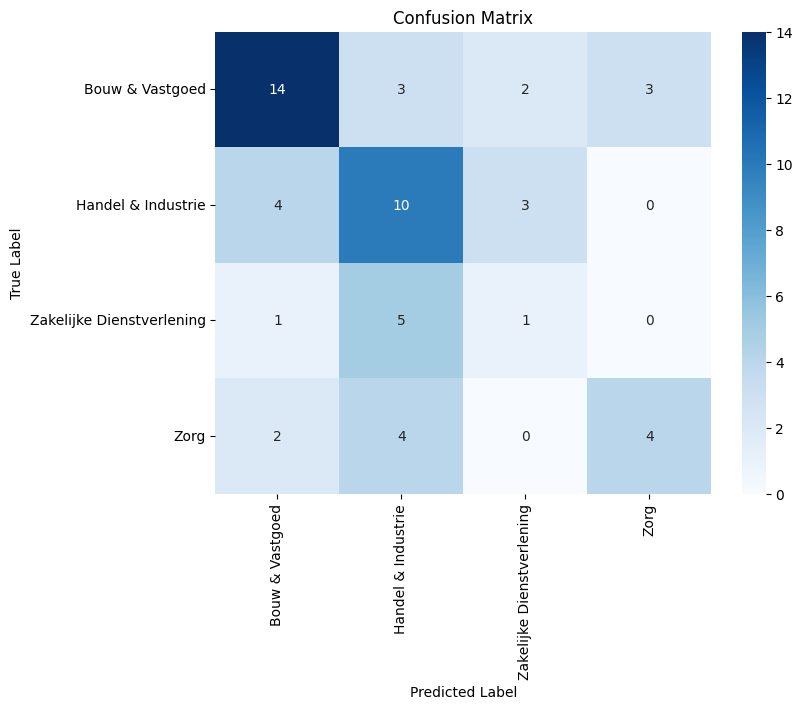

({2: {'accuracy': 0.5531914893617021, 'best_params': 15},
  3: {'accuracy': 0.5460992907801419, 'best_params': 20},
  5: {'accuracy': 0.5659574468085107, 'best_params': None}},
 RandomForestClassifier(random_state=42))

In [123]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2,)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best random_forest Params for k=2: 10, Mean Validation Accuracy: 0.7021
param_results: {5: [0.723404255319149, 0.6170212765957447], 10: [0.7659574468085106, 0.6382978723404256], 15: [0.7659574468085106, 0.6170212765957447], 20: [0.7659574468085106, 0.6170212765957447], None: [0.7659574468085106, 0.6170212765957447]}
mean results: {5: 0.6702127659574468, 10: 0.7021276595744681, 15: 0.6914893617021276, 20: 0.6914893617021276, None: 0.6914893617021276}
best validation accuracy for K=2: 0.7021276595744681
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 10, Mean Validation Accuracy: 0.7305
param_results: {5: [0.7021276595744681, 0.7446808510638298, 0.7021276595744681], 10: [0.723404255319149, 0.7659574468085106, 0.7021276595744681], 15: [0.7446808510638298, 0.7659574468085106, 0.6808510638297872], 20: [0.7446808510638298, 0.7659574468085106, 0.6808510638297872], None: [0.7446808510638298, 0.765957446808510

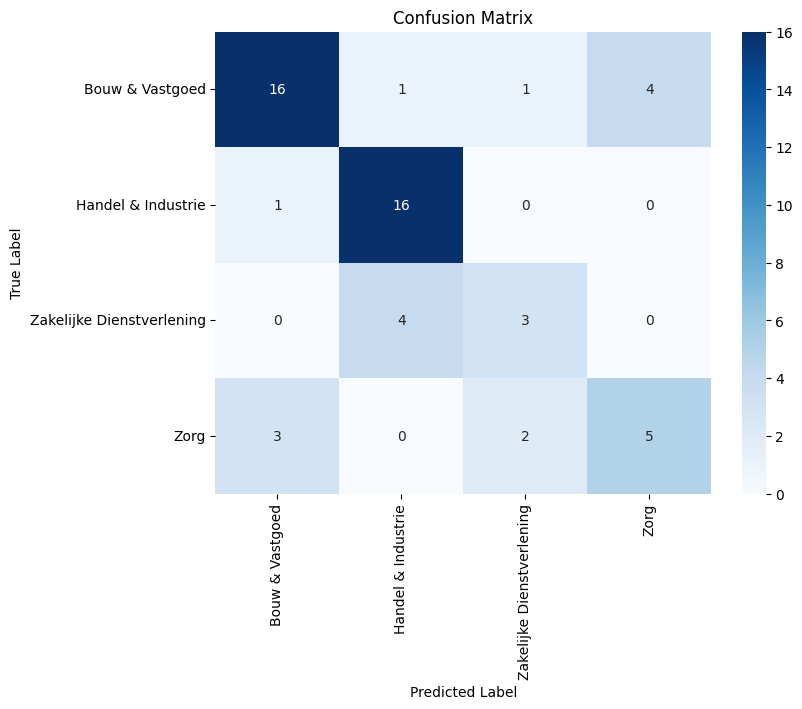

({2: {'accuracy': 0.7021276595744681, 'best_params': 10},
  3: {'accuracy': 0.7304964539007092, 'best_params': 10},
  5: {'accuracy': 0.7319148936170213, 'best_params': 10}},
 RandomForestClassifier(max_depth=10, random_state=42))

In [124]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...

Using One-Hot Encoding for POS Tags...
Best random_forest Params for k=2: 20, Mean Validation Accuracy: 0.4149
param_results: {5: [0.3617021276595745, 0.40425531914893614], 10: [0.3829787234042553, 0.40425531914893614], 15: [0.3617021276595745, 0.44680851063829785], 20: [0.40425531914893614, 0.425531914893617], None: [0.3829787234042553, 0.44680851063829785]}
mean results: {5: 0.3829787234042553, 10: 0.3936170212765957, 15: 0.4042553191489362, 20: 0.4148936170212766, None: 0.4148936170212766}
best validation accuracy for K=2: 0.4148936170212766
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 20, Mean Validation Accuracy: 0.5674
param_results: {5: [0.3404255319148936, 0.48936170212765956, 0.40425531914893614], 10: [0.44680851063829785, 0.5531914893617021, 0.425531914893617], 15: [0.5319148936170213, 0.574468085106383, 0.48936170212765956], 20: [0.5531914893617021, 0.6382978723404256, 0.5106382978723404], None: [0.5319148936170213

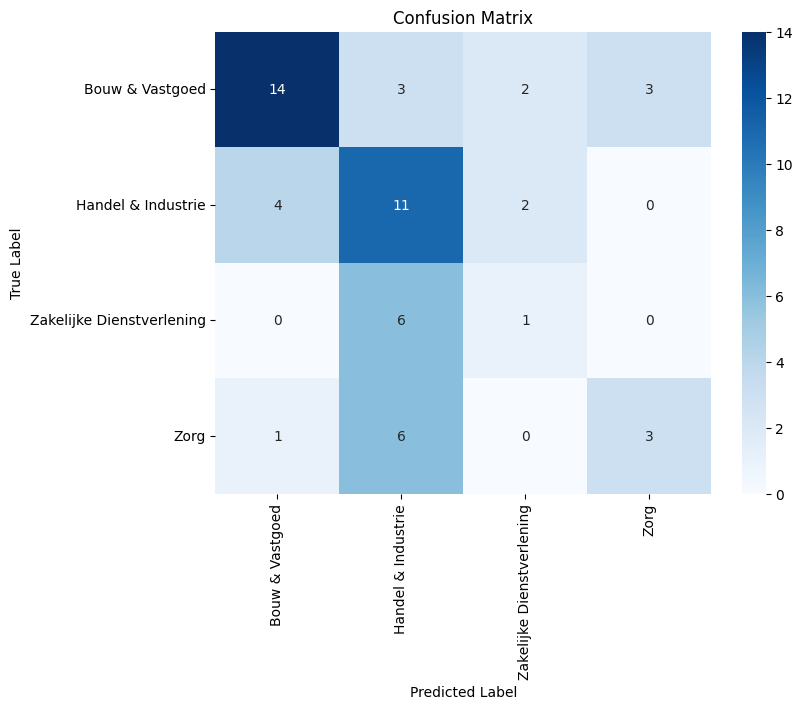

({2: {'accuracy': 0.4148936170212766, 'best_params': 20},
  3: {'accuracy': 0.5673758865248226, 'best_params': 20},
  5: {'accuracy': 0.5319148936170213, 'best_params': 20}},
 RandomForestClassifier(max_depth=20, random_state=42))

In [125]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using MBERT Embeddings (bert-base-multilingual-cased)...

Creating mbert embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best random_forest Params for k=2: 5, Mean Validation Accuracy: 0.6170
param_results: {5: [0.6170212765957447, 0.6170212765957447], 10: [0.574468085106383, 0.6170212765957447], 15: [0.574468085106383, 0.6170212765957447], 20: [0.574468085106383, 0.6170212765957447], None: [0.574468085106383, 0.6170212765957447]}
mean results: {5: 0.6170212765957447, 10: 0.5957446808510638, 15: 0.5957446808510638, 20: 0.5957446808510638, None: 0.5957446808510638}
best validation accuracy for K=2: 0.6170212765957447
best functionwide validation accuracy: 0

Best random_forest Params for k=3: 10, Mean Validation Accuracy: 0.5957
param_results: {5: [0.5957446808510638, 0.5319148936170213, 0.5957446808510638], 10: [0.6170212765957447, 0.6170212765957447, 0.5531914893617021], 15: [0.6170212765957447, 0.5957446808510638, 0.5531914893617021], 20: [0.6170212765957

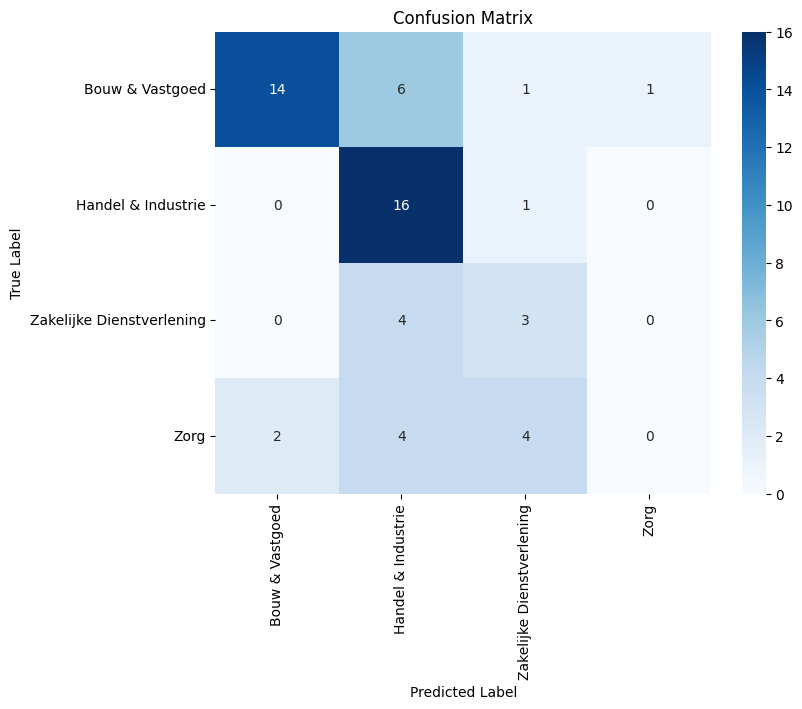

({2: {'accuracy': 0.6170212765957447, 'best_params': 5},
  3: {'accuracy': 0.5957446808510638, 'best_params': 10},
  5: {'accuracy': 0.6297872340425532, 'best_params': 10}},
 RandomForestClassifier(max_depth=10, random_state=42))

In [126]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "mbert", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best svm Params for k=2: (10, 'poly'), Mean Validation Accuracy: 0.8191
param_results: {(0.1, 'linear'): [0.851063829787234, 0.7021276595744681], (0.1, 'rbf'): [0.2127659574468085, 0.2127659574468085], (0.1, 'poly'): [0.2127659574468085, 0.23404255319148937], (1, 'linear'): [0.8297872340425532, 0.7021276595744681], (1, 'rbf'): [0.5319148936170213, 0.5106382978723404], (1, 'poly'): [0.5319148936170213, 0.5319148936170213], (10, 'linear'): [0.8297872340425532, 0.7021276595744681], (10, 'rbf'): [0.8297872340425532, 0.7872340425531915], (10, 'poly'): [0.8723404255319149, 0.7659574468085106]}
mean results: {(0.1, 'linear'): 0.7765957446808511, (0.1, 'rbf'): 0.2127659574468085, (0.1, 'poly'): 0.22340425531914893, (1, 'linear'): 0.7659574468085106, (1, 'rbf'): 0.5212765957446808, (1, 'poly'): 0.5319148936170213, (10, 'linear'): 0.7659574468085106, (10, 'rbf'): 0.8085106382978724, (10, 'poly'): 0.8191489361702128}
best validation accurac

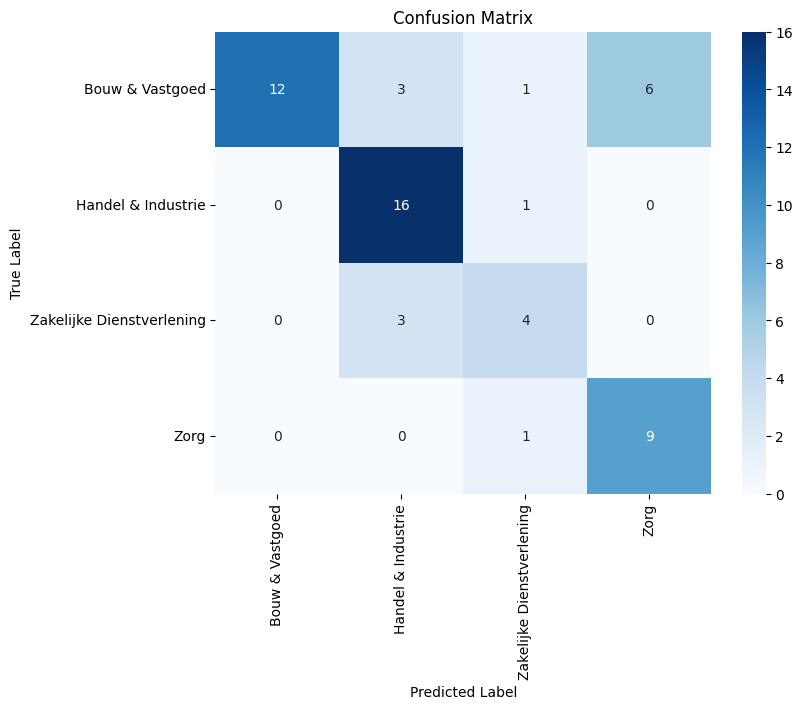

({2: {'accuracy': 0.8191489361702128, 'best_params': (10, 'poly')},
  3: {'accuracy': 0.8439716312056738, 'best_params': (10, 'rbf')},
  5: {'accuracy': 0.8468085106382979, 'best_params': (10, 'rbf')}},
 SVC(C=10))

In [127]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using One-Hot Encoding for POS Tags...
Best svm Params for k=2: (1, 'rbf'), Mean Validation Accuracy: 0.6700
param_results: {(0.1, 'linear'): [0.5, 0.52], (0.1, 'rbf'): [0.36, 0.36], (0.1, 'poly'): [0.36, 0.36], (1, 'linear'): [0.5, 0.52], (1, 'rbf'): [0.68, 0.66], (1, 'poly'): [0.4, 0.46], (10, 'linear'): [0.5, 0.52], (10, 'rbf'): [0.52, 0.56], (10, 'poly'): [0.52, 0.5]}
mean results: {(0.1, 'linear'): 0.51, (0.1, 'rbf'): 0.36, (0.1, 'poly'): 0.36, (1, 'linear'): 0.51, (1, 'rbf'): 0.67, (1, 'poly'): 0.43000000000000005, (10, 'linear'): 0.51, (10, 'rbf'): 0.54, (10, 'poly'): 0.51}
best validation accuracy for K=2: 0.67
best functionwide validation accuracy: 0

Best svm Params for k=3: (1, 'rbf'), Mean Validation Accuracy: 0.6800
param_results: {(0.1, 'linear'): [0.52, 0.5, 0.5], (0.1, 'rbf'): [0.36, 0.36, 0.36], (0.1, 'poly'): [0.36, 0.36, 0.36], (1, 'linear'): [0.52, 0.5, 0.5], (1, 'rbf'): [0.68, 0.66, 0.7], (1, 'poly'): [0.46, 0.44, 0.46], (10

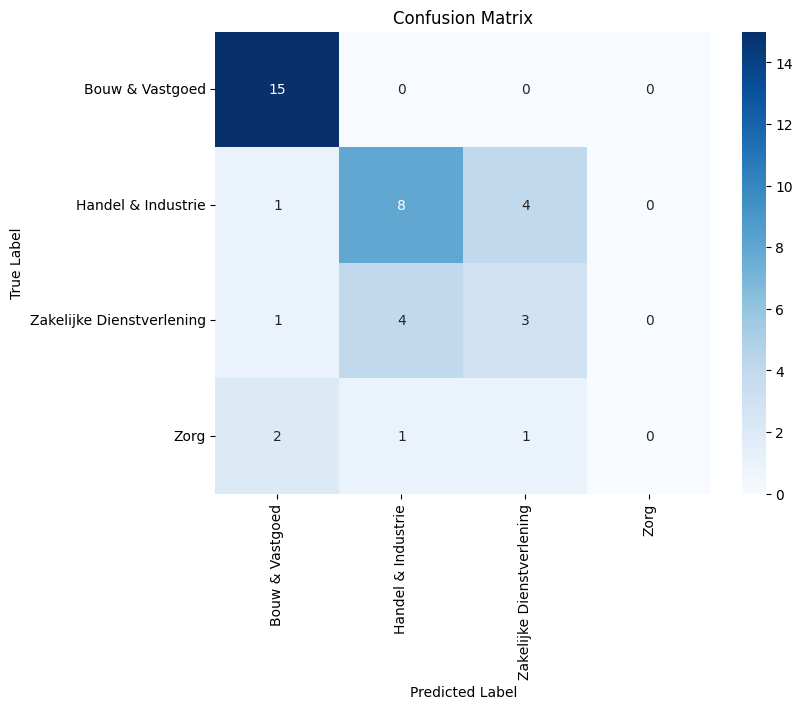

({2: {'accuracy': 0.67, 'best_params': (1, 'rbf')},
  3: {'accuracy': 0.68, 'best_params': (1, 'rbf')},
  5: {'accuracy': 0.6880000000000001, 'best_params': (1, 'rbf')}},
 SVC(C=1))

In [213]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using ROBBERT Embeddings (pdelobelle/robbert-v2-dutch-base)...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating robBERT embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best svm Params for k=2: (1, 'linear'), Mean Validation Accuracy: 0.9149
param_results: {(0.1, 'linear'): [0.8085106382978723, 0.7021276595744681], (0.1, 'rbf'): [0.2127659574468085, 0.2127659574468085], (0.1, 'poly'): [0.2127659574468085, 0.2127659574468085], (1, 'linear'): [0.8723404255319149, 0.9574468085106383], (1, 'rbf'): [0.48936170212765956, 0.5106382978723404], (1, 'poly'): [0.48936170212765956, 0.5106382978723404], (10, 'linear'): [0.8723404255319149, 0.9361702127659575], (10, 'rbf'): [0.7446808510638298, 0.6170212765957447], (10, 'poly'): [0.723404255319149, 0.6595744680851063]}
mean results: {(0.1, 'linear'): 0.7553191489361701, (0.1, 'rbf'): 0.2127659574468085, (0.1, 'poly'): 0.2127659574468085, (1, 'linear'): 0.9148936170212767, (1, 'rbf'): 0.5, (1, 'poly'): 0.5, (10, 'linear'): 0.9042553191489362, (10, 'rbf'): 0.6808510638297872, (10, 'poly'): 0.6914893617021276}
best validation

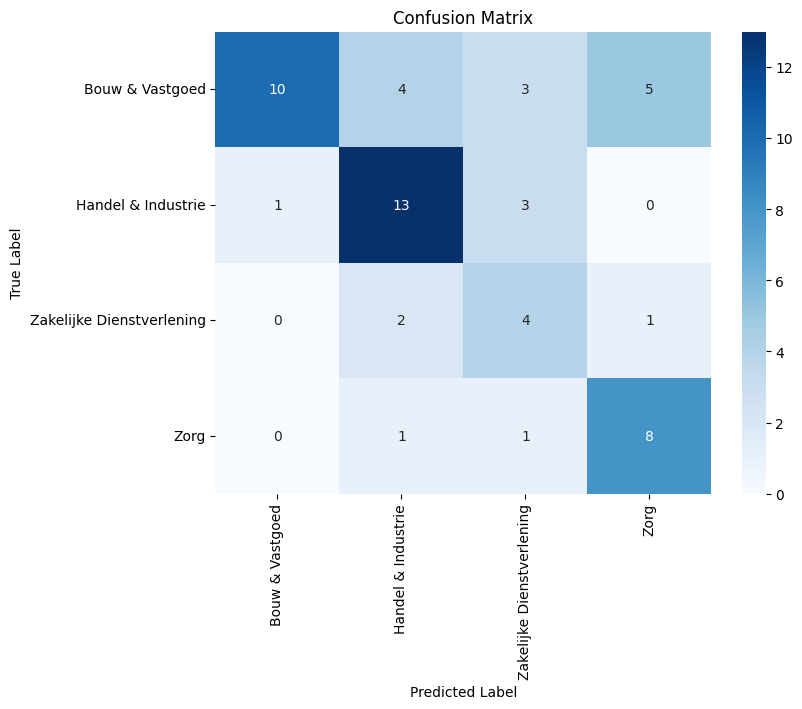

({2: {'accuracy': 0.9148936170212767, 'best_params': (1, 'linear')},
  3: {'accuracy': 0.8368794326241135, 'best_params': (0.1, 'linear')},
  5: {'accuracy': 0.8340425531914895, 'best_params': (10, 'poly')}},
 SVC(C=1, kernel='linear'))

In [129]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "robBERT", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: (0.1, False), Mean Validation Accuracy: 0.6170
param_results: {(0.01, True): [0.6382978723404256, 0.5319148936170213], (0.01, False): [0.6382978723404256, 0.5319148936170213], (0.1, True): [0.6595744680851063, 0.5319148936170213], (0.1, False): [0.6595744680851063, 0.574468085106383], (0.5, True): [0.44680851063829785, 0.3404255319148936], (0.5, False): [0.6382978723404256, 0.5319148936170213], (1.0, True): [0.2978723404255319, 0.2553191489361702], (1.0, False): [0.5531914893617021, 0.44680851063829785], (2.0, True): [0.23404255319148937, 0.2127659574468085], (2.0, False): [0.46808510638297873, 0.3191489361702128], (5.0, True): [0.2127659574468085, 0.2127659574468085], (5.0, False): [0.2765957446808511, 0.2553191489361702], (10.0, True): [0.2127659574468085, 0.2127659574468085], (10.0, False): [0.23404255319148937, 0.2553191489361702]}
mean results: {(0.01, True): 0.5851063829787234, (0.01, False): 0.5851063829787234, (0.1, T

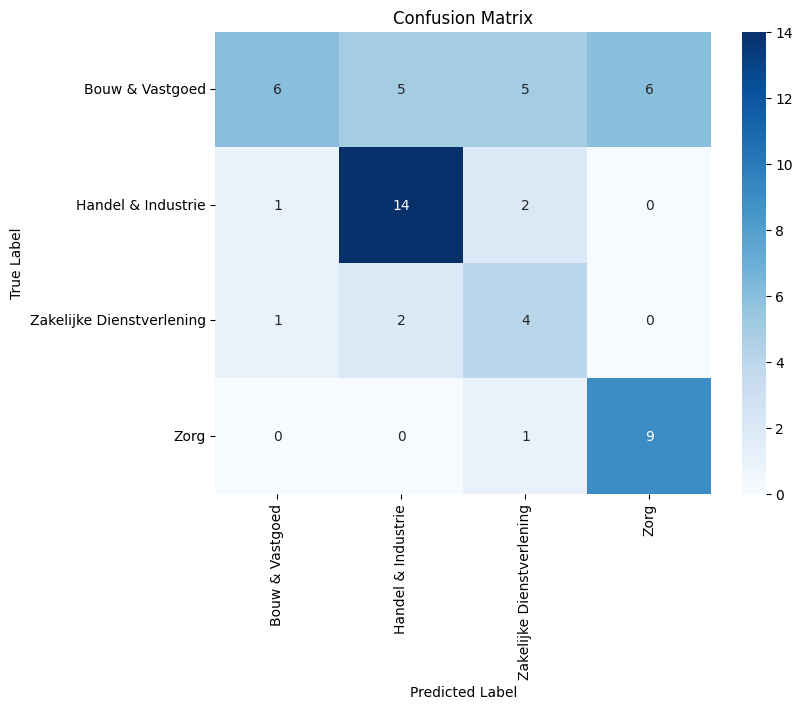

({2: {'accuracy': 0.6170212765957447, 'best_params': (0.1, False)},
  3: {'accuracy': 0.624113475177305, 'best_params': (0.1, False)},
  5: {'accuracy': 0.6170212765957446, 'best_params': (0.1, False)}},
 MultinomialNB(alpha=0.1, fit_prior=False))

In [130]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: (0.1, False), Mean Validation Accuracy: 0.6170
param_results: {(0.01, True): [0.6382978723404256, 0.5319148936170213], (0.01, False): [0.6382978723404256, 0.5319148936170213], (0.1, True): [0.6595744680851063, 0.5319148936170213], (0.1, False): [0.6595744680851063, 0.574468085106383], (0.5, True): [0.44680851063829785, 0.3404255319148936], (0.5, False): [0.6382978723404256, 0.5319148936170213], (1.0, True): [0.2978723404255319, 0.2553191489361702], (1.0, False): [0.5531914893617021, 0.44680851063829785], (2.0, True): [0.23404255319148937, 0.2127659574468085], (2.0, False): [0.46808510638297873, 0.3191489361702128], (5.0, True): [0.2127659574468085, 0.2127659574468085], (5.0, False): [0.2765957446808511, 0.2553191489361702], (10.0, True): [0.2127659574468085, 0.2127659574468085], (10.0, False): [0.23404255319148937, 0.2553191489361702]}
mean results: {(0.01, True): 0.5851063829787234, (0.01, False): 0.5851063829787234, (0.1, T

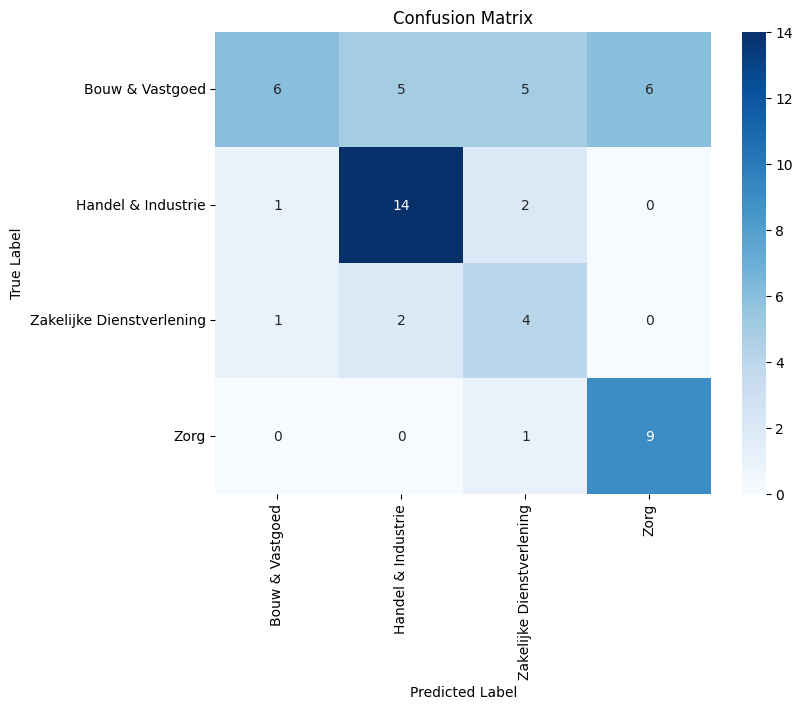

({2: {'accuracy': 0.6170212765957447, 'best_params': (0.1, False)},
  3: {'accuracy': 0.624113475177305, 'best_params': (0.1, False)},
  5: {'accuracy': 0.6170212765957446, 'best_params': (0.1, False)}},
 MultinomialNB(alpha=0.1, fit_prior=False))

In [131]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using N-gram POS Features (n=2)...
Best naive_bayes Params for k=2: 1e-11, Mean Validation Accuracy: 0.5319
param_results: {1e-11: [0.574468085106383, 0.48936170212765956], 1e-10: [0.574468085106383, 0.48936170212765956], 1e-09: [0.574468085106383, 0.48936170212765956], 1e-08: [0.574468085106383, 0.48936170212765956], 1e-07: [0.574468085106383, 0.48936170212765956]}
mean results: {1e-11: 0.5319148936170213, 1e-10: 0.5319148936170213, 1e-09: 0.5319148936170213, 1e-08: 0.5319148936170213, 1e-07: 0.5319148936170213}
best validation accuracy for K=2: 0.5319148936170213
best functionwide validation accuracy: 0

Best naive_bayes Params for k=3: 1e-07, Mean Validation Accuracy: 0.4894
param_results: {1e-11: [0.5106382978723404, 0.48936170212765956, 0.44680851063829785], 1e-10: [0.5106382978723404, 0.48936170212765956, 0.44680851063829785], 1e-09: [0.5106382978723404, 0.48936170212765956, 0.44680851063829785], 1e-08: [0.5106382978723404, 0.4893617021276

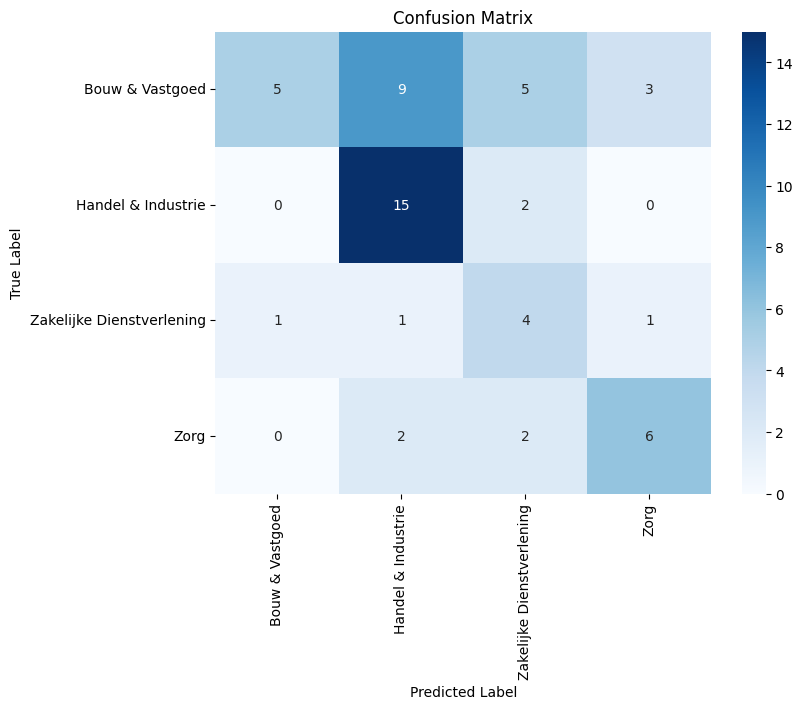

({2: {'accuracy': 0.5319148936170213, 'best_params': 1e-11},
  3: {'accuracy': 0.48936170212765956, 'best_params': 1e-07},
  5: {'accuracy': 0.5148936170212767, 'best_params': 1e-08}},
 GaussianNB(var_smoothing=1e-11))

In [132]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=1: (0.1, False), Mean Validation Accuracy: 0.6383
param_results: {(0.01, True): [0.5957446808510638], (0.01, False): [0.574468085106383], (0.1, True): [0.5531914893617021], (0.1, False): [0.6382978723404256], (0.5, True): [0.46808510638297873], (0.5, False): [0.574468085106383], (1.0, True): [0.3617021276595745], (1.0, False): [0.5319148936170213], (2.0, True): [0.2553191489361702], (2.0, False): [0.46808510638297873], (5.0, True): [0.2127659574468085], (5.0, False): [0.3404255319148936], (10.0, True): [0.2127659574468085], (10.0, False): [0.2553191489361702]}
mean results: {(0.01, True): 0.5957446808510638, (0.01, False): 0.574468085106383, (0.1, True): 0.5531914893617021, (0.1, False): 0.6382978723404256, (0.5, True): 0.46808510638297873, (0.5, False): 0.574468085106383, (1.0, True): 0.3617021276595745, (1.0, False): 0.5319148936170213, (2.0, True): 0.2553191489361702, (2.0, False): 0.46808510638297873, (5.0, True): 0.21276595

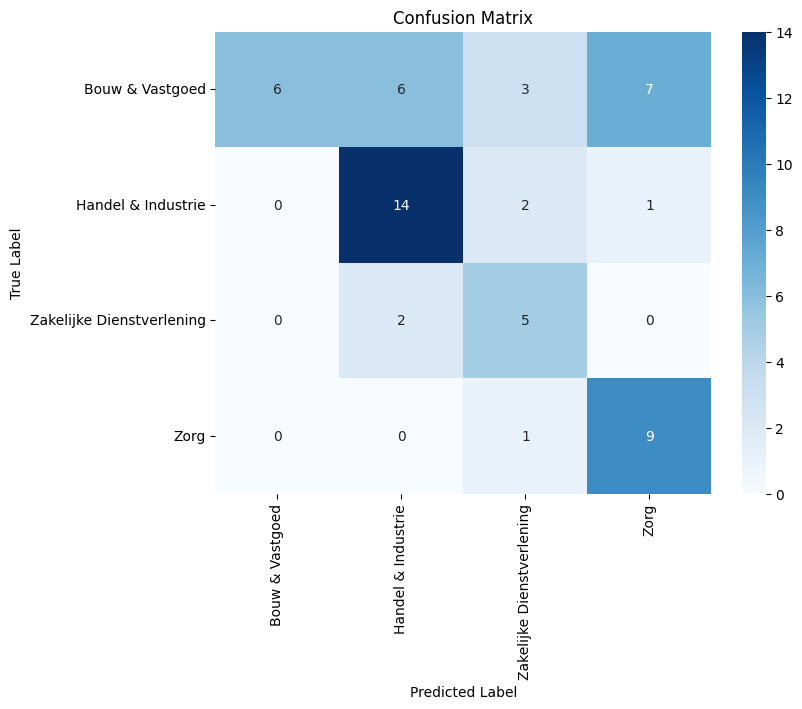

({1: {'accuracy': 0.6382978723404256, 'best_params': (0.1, False)},
  2: {'accuracy': 0.6170212765957447, 'best_params': (0.1, False)},
  3: {'accuracy': 0.624113475177305, 'best_params': (0.1, False)},
  5: {'accuracy': 0.6170212765957446, 'best_params': (0.1, False)},
  10: {'accuracy': 0.625531914893617, 'best_params': (0.1, False)},
  20: {'accuracy': 0.6297872340425531, 'best_params': (0.1, False)}},
 MultinomialNB(alpha=0.1, fit_prior=False))

In [133]:
evaluate_model(df, test_ratio=0.15, k_values=[1, 2, 3, 5, 10, 20],
               embedding="tf-idf", model_type="naive_bayes", pos="none", 
               ngram_size=2, print_updates=True, show_class_accuracy=True, 
               show_confusion_matrix=True, return_data=False,
               save_first_vectorizer=False)

In [ ]:
# To Do:

# -Add some print statements to show the model chosen en parameters, especially for Gaussian- of Multinomial Naive Bayes
# -Print update of best model after every k
# -Clean Code and add/remove/update comments where needed
# -Return actual model and validation accuracy such that we can visualize the results in confusion matrices
# -If 2 classes too close in likelihood or no class likelihood exceeds threshold, then say class 5

# Finding the best model

Our goal is to find the classifier with the highest validation accuracy for each model type

In [19]:
# Ignore all warnings since they cause problems for te progress bars
warnings.simplefilter("ignore")

In [218]:
# Naive Bayes

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="naive_bayes",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██▏                                                               | 1/30 [00:01<00:39,  1.36s/iteration]

Maximum validation accuracy this iteration: 0.72
Best validaton accuracy increased from -inf to 0.72 with params BoW, none, (0.5, True).

testing for embedding=BoW, pos=one-hot, n=2


Progress:   7%|████▍                                                             | 2/30 [00:11<03:03,  6.56s/iteration]

Maximum validation accuracy this iteration: 0.58

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▌                                                           | 3/30 [00:22<03:46,  8.40s/iteration]

Maximum validation accuracy this iteration: 0.66

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▊                                                         | 4/30 [00:33<04:09,  9.59s/iteration]

Maximum validation accuracy this iteration: 0.6533333333333333

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|███████████                                                       | 5/30 [00:49<04:54, 11.78s/iteration]

Maximum validation accuracy this iteration: 0.6266666666666666

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|█████████████▏                                                    | 6/30 [00:51<03:22,  8.45s/iteration]

Maximum validation accuracy this iteration: 0.7220000000000001
Best validaton accuracy increased from 0.72 to 0.7220000000000001 with params tf-idf, none, (0.1, True).

testing for embedding=tf-idf, pos=one-hot, n=2


Progress:  23%|███████████████▍                                                  | 7/30 [01:01<03:27,  9.01s/iteration]

Maximum validation accuracy this iteration: 0.52

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|█████████████████▌                                                | 8/30 [01:11<03:26,  9.39s/iteration]

Maximum validation accuracy this iteration: 0.6266666666666666

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|███████████████████▊                                              | 9/30 [01:22<03:28,  9.91s/iteration]

Maximum validation accuracy this iteration: 0.6466666666666666

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|█████████████████████▋                                           | 10/30 [01:35<03:38, 10.90s/iteration]

Maximum validation accuracy this iteration: 0.64

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|███████████████████████▊                                         | 11/30 [03:58<16:13, 51.26s/iteration]

Maximum validation accuracy this iteration: 0.75
Best validaton accuracy increased from 0.7220000000000001 to 0.75 with params BERTje, none, 1e-11.

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  40%|██████████████████████████                                       | 12/30 [05:56<21:25, 71.43s/iteration]

Maximum validation accuracy this iteration: 0.521

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|████████████████████████████▏                                    | 13/30 [08:01<24:51, 87.73s/iteration]

Maximum validation accuracy this iteration: 0.64

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|██████████████████████████████▎                                  | 14/30 [10:00<25:55, 97.25s/iteration]

Maximum validation accuracy this iteration: 0.5

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|████████████████████████████████                                | 15/30 [11:59<25:55, 103.73s/iteration]

Maximum validation accuracy this iteration: 0.29333333333333333

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|██████████████████████████████████▏                             | 16/30 [13:55<25:02, 107.34s/iteration]

Maximum validation accuracy this iteration: 0.7

testing for embedding=mBERT, pos=one-hot, n=2


Progress:  57%|████████████████████████████████████▎                           | 17/30 [16:08<24:56, 115.14s/iteration]

Maximum validation accuracy this iteration: 0.54

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|██████████████████████████████████████▍                         | 18/30 [18:28<24:32, 122.73s/iteration]

Maximum validation accuracy this iteration: 0.58

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|████████████████████████████████████████▌                       | 19/30 [20:24<22:06, 120.58s/iteration]

Maximum validation accuracy this iteration: 0.46

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|██████████████████████████████████████████▋                     | 20/30 [22:06<19:11, 115.20s/iteration]

Maximum validation accuracy this iteration: 0.29333333333333333

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|████████████████████████████████████████████▊                   | 21/30 [23:53<16:53, 112.63s/iteration]

Maximum validation accuracy this iteration: 0.7280000000000001

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  73%|██████████████████████████████████████████████▉                 | 22/30 [25:42<14:52, 111.54s/iteration]

Maximum validation accuracy this iteration: 0.52

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|█████████████████████████████████████████████████               | 23/30 [27:25<12:42, 108.91s/iteration]

Maximum validation accuracy this iteration: 0.5820000000000001

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|███████████████████████████████████████████████████▏            | 24/30 [29:18<11:01, 110.28s/iteration]

Maximum validation accuracy this iteration: 0.5

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|█████████████████████████████████████████████████████▎          | 25/30 [31:35<09:51, 118.22s/iteration]

Maximum validation accuracy this iteration: 0.29333333333333333

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|████████████████████████████████████████████████████████▎        | 26/30 [31:36<05:31, 82.95s/iteration]

Maximum validation accuracy this iteration: 0.35

testing for embedding=Word2Vec, pos=one-hot, n=2


Progress:  90%|██████████████████████████████████████████████████████████▌      | 27/30 [31:37<02:55, 58.35s/iteration]

Maximum validation accuracy this iteration: 0.52

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|████████████████████████████████████████████████████████████▋    | 28/30 [31:37<01:22, 41.08s/iteration]

Maximum validation accuracy this iteration: 0.34

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|██████████████████████████████████████████████████████████████▊  | 29/30 [31:39<00:29, 29.16s/iteration]

Maximum validation accuracy this iteration: 0.42

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|█████████████████████████████████████████████████████████████████| 30/30 [31:40<00:00, 63.36s/iteration]

Maximum validation accuracy this iteration: 0.29333333333333333
Best overall model: ('BERTje', 'none', 2)
Best overall accuracy: 0.75
Best overall parameters: 1e-11


In [35]:
# Support Vector Machine

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="svm",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")
            
            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██▏                                                               | 1/30 [00:15<07:38, 15.81s/iteration]

Maximum validation accuracy this iteration: 0.7933333333333333
Best validaton accuracy increased from -inf to 0.7933333333333333 with params BoW, none, (10, 'rbf').

testing for embedding=BoW, pos=one-hot, n=2


Progress:   7%|████▍                                                             | 2/30 [00:43<10:30, 22.53s/iteration]

Maximum validation accuracy this iteration: 0.691

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▌                                                           | 3/30 [01:05<10:03, 22.36s/iteration]

Maximum validation accuracy this iteration: 0.79

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▊                                                         | 4/30 [01:34<10:50, 25.02s/iteration]

Maximum validation accuracy this iteration: 0.788

testing for embedding=BoW, pos=ngram, n=5


Progress:  13%|████████▊                                                         | 4/30 [01:45<11:27, 26.43s/iteration]

KeyboardInterrupt



In [64]:
# Random Forest

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1

            print(f"\ntesting for embedding={embedding}, pos={pos}, n={n}")
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="random_forest",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)[0]

            # Find the best model in this iteration
            global_best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            global_best_model_key = global_best_model[0]
            best_accuracy = global_best_model[1]['accuracy']
            best_params = global_best_model[1]['best_params']

            print(f"Maximum validation accuracy this iteration: {best_accuracy}")

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                print(f"Best validaton accuracy increased from {best_overall_accuracy} to {best_accuracy} with params {embedding}, {pos}, {best_params}.")
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, global_best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]


testing for embedding=BoW, pos=none, n=2


Progress:   3%|██                                                             | 1/30 [06:20<3:03:41, 380.06s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334
Best validaton accuracy increased from -inf to 0.5833333333333334 with params BoW, none, 15.

testing for embedding=BoW, pos=one-hot, n=2


Progress:   7%|████▏                                                          | 2/30 [12:22<2:52:25, 369.48s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=BoW, pos=ngram, n=2


Progress:  10%|██████▎                                                        | 3/30 [18:53<2:50:43, 379.39s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666
Best validaton accuracy increased from 0.5833333333333334 to 0.6041666666666666 with params BoW, ngram, 5.

testing for embedding=BoW, pos=ngram, n=3


Progress:  13%|████████▍                                                      | 4/30 [27:05<3:03:37, 423.73s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=BoW, pos=ngram, n=5


Progress:  17%|██████████▌                                                    | 5/30 [34:05<2:56:02, 422.49s/iteration]

Maximum validation accuracy this iteration: 0.5625

testing for embedding=tf-idf, pos=none, n=2


Progress:  20%|████████████▌                                                  | 6/30 [39:22<2:34:39, 386.64s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=tf-idf, pos=one-hot, n=2


Progress:  23%|██████████████▋                                                | 7/30 [44:59<2:21:58, 370.39s/iteration]

Maximum validation accuracy this iteration: 0.625
Best validaton accuracy increased from 0.6041666666666666 to 0.625 with params tf-idf, one-hot, 10.

testing for embedding=tf-idf, pos=ngram, n=2


Progress:  27%|████████████████▊                                              | 8/30 [51:21<2:17:11, 374.15s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=tf-idf, pos=ngram, n=3


Progress:  30%|██████████████████▉                                            | 9/30 [59:23<2:22:48, 408.01s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=tf-idf, pos=ngram, n=5


Progress:  33%|████████████████████                                        | 10/30 [1:06:26<2:17:31, 412.55s/iteration]

Maximum validation accuracy this iteration: 0.5204166666666666

testing for embedding=BERTje, pos=none, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  37%|██████████████████████                                      | 11/30 [1:11:24<1:59:30, 377.38s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334
Best validaton accuracy increased from 0.625 to 0.6458333333333334 with params BERTje, none, 15.

testing for embedding=BERTje, pos=one-hot, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  40%|████████████████████████                                    | 12/30 [1:18:00<1:54:54, 383.03s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=2


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  43%|██████████████████████████                                  | 13/30 [1:24:28<1:49:00, 384.74s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=3


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  47%|████████████████████████████                                | 14/30 [1:31:24<1:45:06, 394.17s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=BERTje, pos=ngram, n=5


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  50%|██████████████████████████████                              | 15/30 [1:38:47<1:42:13, 408.89s/iteration]

Maximum validation accuracy this iteration: 0.6666666666666666
Best validaton accuracy increased from 0.6458333333333334 to 0.6666666666666666 with params BERTje, ngram, 15.

testing for embedding=mBERT, pos=none, n=2


Progress:  53%|████████████████████████████████                            | 16/30 [1:44:31<1:30:47, 389.09s/iteration]

Maximum validation accuracy this iteration: 0.6041666666666666

testing for embedding=mBERT, pos=one-hot, n=2


Progress:  57%|██████████████████████████████████                          | 17/30 [1:51:09<1:24:53, 391.82s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=mBERT, pos=ngram, n=2


Progress:  60%|████████████████████████████████████                        | 18/30 [1:57:42<1:18:26, 392.23s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=mBERT, pos=ngram, n=3


Progress:  63%|██████████████████████████████████████                      | 19/30 [2:04:36<1:13:07, 398.86s/iteration]

Maximum validation accuracy this iteration: 0.5833333333333334

testing for embedding=mBERT, pos=ngram, n=5


Progress:  67%|████████████████████████████████████████                    | 20/30 [2:11:37<1:07:34, 405.40s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=none, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  70%|███████████████████████████████████████████▍                  | 21/30 [2:16:35<56:00, 373.35s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=RobBERT, pos=one-hot, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  73%|█████████████████████████████████████████████▍                | 22/30 [2:23:12<50:43, 380.41s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=ngram, n=2


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  77%|███████████████████████████████████████████████▌              | 23/30 [2:29:46<44:51, 384.43s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=RobBERT, pos=ngram, n=3


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  80%|█████████████████████████████████████████████████▌            | 24/30 [2:36:43<39:24, 394.05s/iteration]

Maximum validation accuracy this iteration: 0.625

testing for embedding=RobBERT, pos=ngram, n=5


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Progress:  83%|███████████████████████████████████████████████████▋          | 25/30 [2:43:48<33:36, 403.36s/iteration]

Maximum validation accuracy this iteration: 0.6458333333333334

testing for embedding=Word2Vec, pos=none, n=2


Progress:  87%|█████████████████████████████████████████████████████▋        | 26/30 [2:46:10<21:40, 325.15s/iteration]

Maximum validation accuracy this iteration: 0.34500000000000003

testing for embedding=Word2Vec, pos=one-hot, n=2


Progress:  90%|███████████████████████████████████████████████████████▊      | 27/30 [2:49:26<14:18, 286.26s/iteration]

Maximum validation accuracy this iteration: 0.4038035339922132

testing for embedding=Word2Vec, pos=ngram, n=2


Progress:  93%|█████████████████████████████████████████████████████████▊    | 28/30 [2:52:37<08:35, 257.84s/iteration]

Maximum validation accuracy this iteration: 0.441633064516129

testing for embedding=Word2Vec, pos=ngram, n=3


Progress:  97%|███████████████████████████████████████████████████████████▉  | 29/30 [2:56:13<04:05, 245.12s/iteration]

Maximum validation accuracy this iteration: 0.41949685534591197

testing for embedding=Word2Vec, pos=ngram, n=5


Progress: 100%|██████████████████████████████████████████████████████████████| 30/30 [2:59:55<00:00, 359.83s/iteration]

Maximum validation accuracy this iteration: 0.37583333333333335
Best overall model: ('BERTje', 'ngram', 1)
Best overall accuracy: 0.6666666666666666
Best overall parameters: 15



Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best naive_bayes Params for k=1: 1e-11, Mean Validation Accuracy: 0.7400
param_results: {1e-11: [0.74], 1e-10: [0.74], 1e-09: [0.74], 1e-08: [0.74], 1e-07: [0.74]}
mean results: {1e-11: 0.74, 1e-10: 0.74, 1e-09: 0.74, 1e-08: 0.74, 1e-07: 0.74}
best validation accuracy for K=1: 0.74
best functionwide validation accuracy: 0

Best naive_bayes Params for k=2: 1e-11, Mean Validation Accuracy: 0.7500
param_results: {1e-11: [0.74, 0.76], 1e-10: [0.74, 0.76], 1e-09: [0.74, 0.76], 1e-08: [0.74, 0.76], 1e-07: [0.74, 0.76]}
mean results: {1e-11: 0.75, 1e-10: 0.75, 1e-09: 0.75, 1e-08: 0.75, 1e-07: 0.75}
best validation accuracy for K=2: 0.75
best functionwide validation accuracy: 0.74

Best naive_bayes Params for k=3: 1e-11, Mean Validation Accuracy: 0.7400
param_results: {1e-11: [0.74, 0.74, 0.74], 1e-10: [0.74, 0.74, 0.74], 1e-09: [0.74, 0.74, 0.74], 1e-08: [0.74, 0.74, 0.74], 1e-07: [0.74, 0.74, 0.74]}
mean results: {1e-11: 0.739999999999

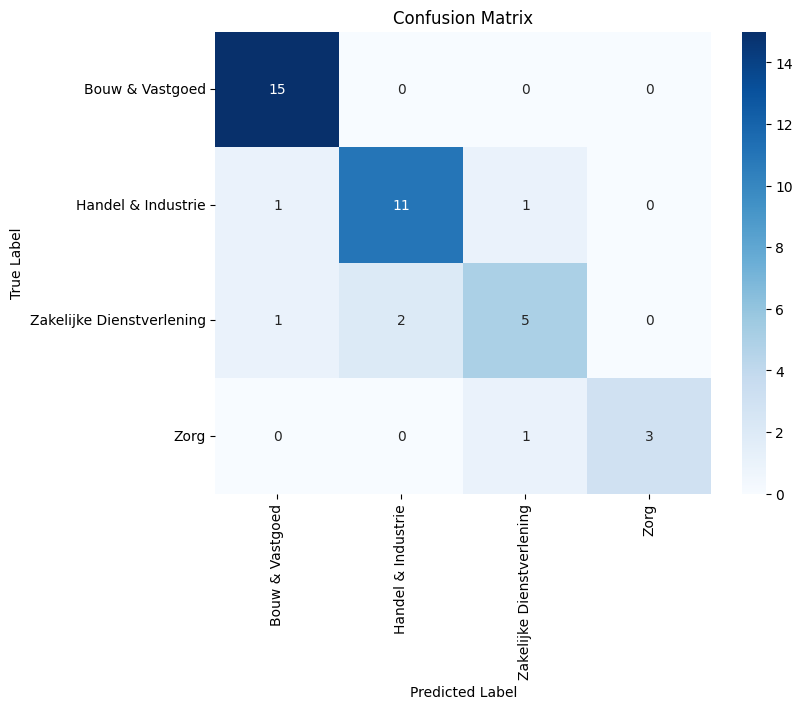

In [220]:
# Model with best validation accuracy:

final_results = evaluate_model(df, 
                               test_ratio=0.15, 
                               k_values=[1, 2, 3, 5, 10, 20],
                               embedding="BERTje", 
                               model_type="naive_bayes",
                               pos="none", 
                               ngram_size=2,
                               print_updates=True,
                               show_class_accuracy=True, 
                               show_confusion_matrix=True,
                               return_data=True)

final_performance, final_nb, data_final_model = final_results[0], final_results[1], final_results[2]


Using ROBBERT Embeddings (pdelobelle/robbert-v2-dutch-base)...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating RobBERT embedding, this may take a few minutes.
Best svm Params for k=1: (10, 'rbf'), Mean Validation Accuracy: 0.8600
param_results: {(0.1, 'linear'): [0.76], (0.1, 'rbf'): [0.36], (0.1, 'poly'): [0.38], (1, 'linear'): [0.68], (1, 'rbf'): [0.72], (1, 'poly'): [0.72], (10, 'linear'): [0.68], (10, 'rbf'): [0.86], (10, 'poly'): [0.74]}
mean results: {(0.1, 'linear'): 0.76, (0.1, 'rbf'): 0.36, (0.1, 'poly'): 0.38, (1, 'linear'): 0.68, (1, 'rbf'): 0.72, (1, 'poly'): 0.72, (10, 'linear'): 0.68, (10, 'rbf'): 0.86, (10, 'poly'): 0.74}
best validation accuracy for K=1: 0.86
best functionwide validation accuracy: 0

Best svm Params for k=2: (0.1, 'linear'), Mean Validation Accuracy: 0.7700
param_results: {(0.1, 'linear'): [0.74, 0.8], (0.1, 'rbf'): [0.36, 0.36], (0.1, 'poly'): [0.36, 0.36], (1, 'linear'): [0.76, 0.72], (1, 'rbf'): [0.68, 0.68], (1, 'poly'): [0.7, 0.7], (10, 'linear'): [0.76, 0.72], (10, 'rbf'): [0.74, 0.76], (10, 'poly'): [0.74, 0.74]}
mean results: {(0.1, 'linear'): 

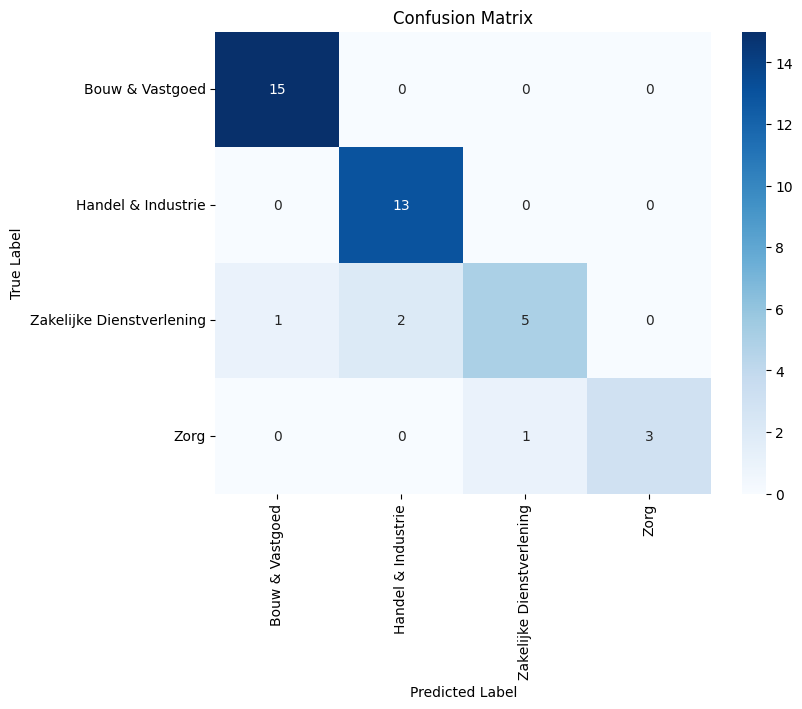

In [228]:
# Model with best validation accuracy:

final_results = evaluate_model(df, 
                               test_ratio=0.15, 
                               k_values=[1, 2, 3, 5, 10, 20],
                               embedding="RobBERT", 
                               model_type="svm",
                               pos="none", 
                               ngram_size=2,
                               print_updates=True,
                               show_class_accuracy=True, 
                               show_confusion_matrix=True,
                               return_data=True)

final_performance, final_nb, data_final_model = final_results[0], final_results[1], final_results[2]


Using ROBBERT Embeddings (pdelobelle/robbert-v2-dutch-base)...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating RobBERT embedding, this may take a few minutes.
Best svm Params for k=1: (10, 'rbf'), Mean Validation Accuracy: 0.8600
param_results: {(0.1, 'linear'): [0.76], (0.1, 'rbf'): [0.36], (0.1, 'poly'): [0.38], (1, 'linear'): [0.68], (1, 'rbf'): [0.72], (1, 'poly'): [0.72], (10, 'linear'): [0.68], (10, 'rbf'): [0.86], (10, 'poly'): [0.74]}
mean results: {(0.1, 'linear'): 0.76, (0.1, 'rbf'): 0.36, (0.1, 'poly'): 0.38, (1, 'linear'): 0.68, (1, 'rbf'): 0.72, (1, 'poly'): 0.72, (10, 'linear'): 0.68, (10, 'rbf'): 0.86, (10, 'poly'): 0.74}
best validation accuracy for K=1: 0.86
best functionwide validation accuracy: 0

Best svm Params for k=2: (0.1, 'linear'), Mean Validation Accuracy: 0.7700
param_results: {(0.1, 'linear'): [0.74, 0.8], (0.1, 'rbf'): [0.36, 0.36], (0.1, 'poly'): [0.36, 0.36], (1, 'linear'): [0.76, 0.72], (1, 'rbf'): [0.68, 0.68], (1, 'poly'): [0.7, 0.7], (10, 'linear'): [0.76, 0.72], (10, 'rbf'): [0.74, 0.76], (10, 'poly'): [0.74, 0.74]}
mean results: {(0.1, 'linear'): 

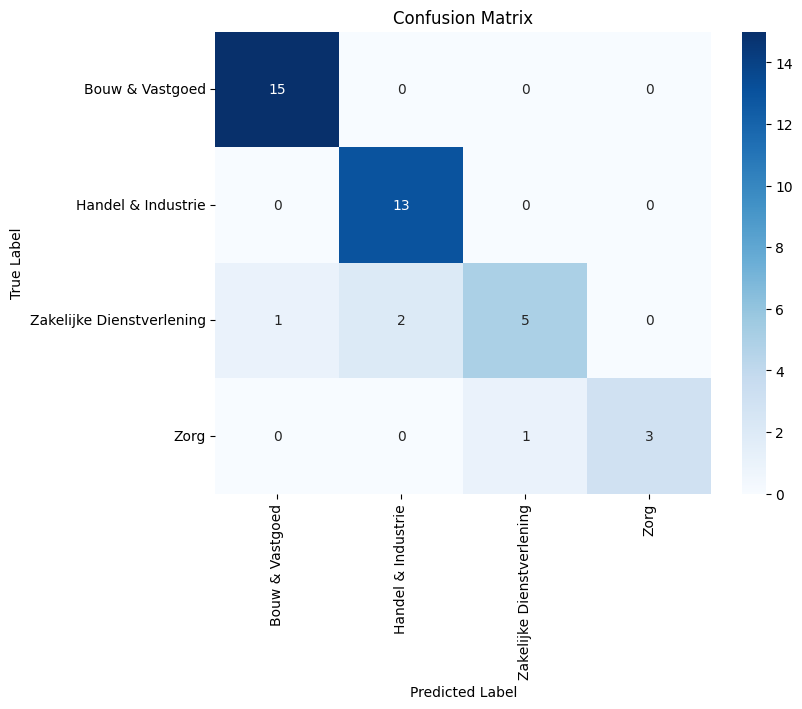

In [34]:
# Model with best validation accuracy:

final_results = evaluate_model(df, 
                               test_ratio=0.15, 
                               k_values=[1, 2, 3, 5, 10, 20],
                               embedding="RobBERT", 
                               model_type="svm",
                               pos="none", 
                               ngram_size=2,
                               print_updates=True,
                               show_class_accuracy=True, 
                               show_confusion_matrix=True,
                               return_data=True)

final_performance, final_nb, data_final_model = final_results[0], final_results[1], final_results[2]

In [226]:
# TEST OP 2025 artikelen

# Test on unseen 2025 news articles

This section aims to test the obtained classifier for 32 unseen articles, 8 for each class. <br>
To achieve this, we first load the data

In [11]:
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

directory = '2025 test set'
df_experiment = pd.DataFrame(columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])

print('Please ensure that only pdf files of articles are present in the subfolders of the specified directory')
article_nr = 1
for folder in os.listdir(directory):
    folder_size = len(os.listdir(directory + "\\" + folder))
    print(f'{folder_size} article(s) detected in {folder} folder')
    
    for article in os.listdir(directory + '\\' + folder):
        text = extract_text_from_pdf(directory + '\\' + folder + '\\' + article)
        date = article.split(' ')[-1].split('.')[0] #Remove the article number and ".pdf" to obtain the publication date
        
        paragraphs = [para.strip() for para in text.split("\n \n") if para.strip()]
        para_nr = 1
        for para in paragraphs:
            df_temp = pd.DataFrame([[article_nr, para_nr, para, folder, date]], 
                                   columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])
            df_experiment = pd.concat([df_experiment, df_temp])
            para_nr += 1
        article_nr += 1
        
df_experiment.set_index(['article_id' , 'paragraph_id'], inplace=True)
df_experiment['publication_date'] = pd.to_datetime(df_experiment['publication_date'], format='%d-%m-%Y')

Please ensure that only pdf files of articles are present in the subfolders of the specified directory
10 article(s) detected in Bouw & Vastgoed folder
7 article(s) detected in Handel & Industrie folder
8 article(s) detected in Zakelijke Dienstverlening folder
8 article(s) detected in Zorg folder


In [230]:
df_experiment

text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Accountants Deloitte overtraden beroepsregels ...   
           2             ‘Passende maatregelen’ \n‘Ons interne onderzoe...   
           3             Scholen vinden lastig een accountant \nDe onde...   

                                             group publication_date  
article_id paragraph_id                                              
1          1                       Bouw & Vastgoed       2024-12-23  
           2                       Bouw & Vastgoed       2024-12-23  
           3                       Bouw & Vastgoed       2024-12-23  
           4                       Bouw & Vastgoed       2024-12-23  
2          1             Zakelijke Dienstverlening       2025-01-06  
           2             Zakelijke Dienstverlening       2025-01-06  
           3             Zakelijke Dienstverlening       2025-01-06

In [231]:
# Load the 'nl_core_news_sm' model
nlp = spacy.load('nl_core_news_sm')

# Add [NEWLINE] as a single token so that it is not split into 3 seperate tokens
special_cases = {"[NEWLINE]": [{"ORTH": "[NEWLINE]"}]}
nlp.tokenizer.add_special_case("[NEWLINE]", [{"ORTH": "[NEWLINE]"}])

df_experiment_clean = df_experiment.copy()
df_experiment_clean['original_text'] = df_experiment_clean['text'].copy()
df_experiment_clean = df_experiment_clean[['original_text', 'text', 'group']]

In [232]:
def case_normalization(text):
    """Returns string of input containing only lowercase letters apart from [NEWLINE], which replaces \n"""
    text = text.lower()
    text = text.replace('\n', ' [NEWLINE] ')
    while text != text.replace('  ', ' '):
        text = text.replace('  ', ' ')
    return text

df_experiment_clean['text'] = df_experiment_clean['text'].apply(case_normalization)

In [233]:
def remove_punctuation(text):
    """Returns the input text with all punctuation removed"""
    
    text = text.translate(text.maketrans("", "", string.punctuation))
    text = text.replace("NEWLINE", "[NEWLINE]")
    return text

df_experiment_clean['text'] = df_experiment_clean['text'].apply(remove_punctuation)

In [234]:
def remove_stopwords(text):
    """Returns string of input text with stopwords removed"""
    
    doc = nlp(text)
    filtered_words = [token.text for token in doc if not token.is_stop]
    text = " ".join(filtered_words)
    return text
    
    
# nlp = spacy.load("nl_core_news_sm")
df_experiment_clean['text'] = df_experiment_clean['text'].apply(remove_stopwords)

In [235]:
def lemmatization(df, text_column="text", output_column="text"):
    """Lemmatizes the text in a specified column of a DataFrame and adds the results to a new column."""
    
    # Ensure the input column exists in the DataFrame
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' does not exist in the DataFrame.")
        
    # Apply SpaCy processing and lemmatization
    df[output_column] = df[text_column].apply(
        lambda text: " ".join([token.lemma_ for token in nlp(text) if not token.is_punct and not token.is_space]))
    
    return df

df_experiment_clean['text before lemmatization'] = df_experiment_clean['text'].copy()
df_experiment_clean = lemmatization(df_experiment_clean, text_column="text")

In [236]:
def POS_tagging(text):
    """Returns a list of (token, POS tag) tuples for the input text"""
    doc = nlp(text)
    pos_tags = [(token.text, token.pos_) for token in doc]
    return pos_tags

df_experiment_clean['pos_tags'] = df_experiment_clean['text'].apply(POS_tagging)

In [237]:
df_experiment_clean

original_text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Accountants Deloitte overtraden beroepsregels ...   
           2             ‘Passende maatregelen’ \n‘Ons interne onderzoe...   
           3             Scholen vinden lastig een accountant \nDe onde...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             huis 12 duur november groot stijging ruim twee...   
           2             jarenlange daling huizenprijzen beginnen 2013 ...   
           3             november wisselden 17973 woning eigenaar 18 tr...   
           4             corrigeren inflatie huizenprijzen Nederland 20...   
2          1             accountant deloiten overtraen beroepsregel ond...   
           2             passen maatregel [NEWLINE] intern onderzoek af...   
           3             school vinden lastig accountant [NEWLINE] onde...   

                                             group  \
article_id paragraph_id                              
1          1                       Bouw & Vastgoed   
           2                       Bouw & Vastgoed   
           3                       Bouw & Vastgoed   
           4                       Bouw & Vastgoed   
2          1             Zakelijke Dienstverlening   
           2             Zakelijke Dienstverlening   
           3             Zakelijke Dienstverlening   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             huizen 12 duurder november grootste stijging r...   
           2             jarenlange dalingen huizenprijzen begonnen 201...   
           3             november wisselden 17973 woningen eigenaar 18 ...   
           4             gecorrigeerd inflatie huizenprijzen nederland ...   
2          1             accountants deloitte overtraden beroepsregels ...   
           2             ‘ passende maatregelen ’ [NEWLINE] ‘ interne o...   
           3             scholen vinden lastig accountant [NEWLINE] ond...   

                                                                  pos_tags  
article_id paragraph_id                                                     
1          1             [(huis, NOUN), (12, NUM), (duur, NOUN), (novem...  
           2             [(jarenlange, ADJ), (daling, NOUN), (huizenpri...  
           3             [(november, PROPN), (wisselden, VERB), (17973,...  
           4             [(corrigeren, ADJ), (inflatie, NOUN), (huizenp...  
2          1             [(accountant, NOUN), (deloiten, VERB), (overtr...  
           2             [(passen, VERB), (maatregel, NOUN), ([NEWLINE]...  
           3             [(school, NOUN), (vinden, VERB), (lastig, ADJ)...

In [238]:
# Now we feed the data to the best model we found

df["label"] = df["group"].astype("category").cat.codes 
df_experiment_clean["label"] = df_experiment_clean["group"].astype("category").cat.codes 
df_train, df_test = train_test_split(df, test_size=0.15, stratify=df["label"], random_state=42)

# Though we do not need to retrain the model, we do need to fit_transform it using tf-idf so that we can transform X_test the same way.
vectorizer = TfidfVectorizer(max_features=10_000)
X_train = vectorizer.fit_transform(df["text"])
X_test = vectorizer.transform(df_experiment_clean["text"])
y_test = df_experiment_clean["label"]

y_pred = final_nb.predict(X_test)
test_accuracy = accuracy_score(y_test, final_nb.predict(X_test))
test_accuracy

ValueError: X has 7214 features, but SVC is expecting 768 features as input.

In [ ]:
y_pred

We can see that the classifier performs quite well for the first article (75% accurate). For the 2nd article however, all paragraphs have been classified incorrectly.

# Adding class 5 (uncertain class) to the classifier

Firstly, we start by visualizing the following 2 aspects of our resulting classifier: <br>
> - The maximum predicted probability amongs the 4 classes for each individual instance
> - The difference in predicted probability between the most and second most likely class for each individual instance.

In [99]:
X_train_final_model, y_train_final_model = data_final_model[0][0], data_final_model[0][1]
X_val_final_model, y_val_final_model = data_final_model[1][0], data_final_model[1][1]
X_test_final_model, y_test_final_model = data_final_model[2][0], data_final_model[2][1]

y_pred_test = final_nb.predict(X_test_final_model)
y_pred_test_proba = final_nb.predict_proba(X_test_final_model)
y_pred_test_proba_max = [max(probs) for probs in y_pred_test_proba]
y_pred_test_proba_diff = [sorted(probs, reverse=True)[0] - sorted(probs, reverse=True)[1] for probs in y_pred_test_proba]

In [100]:
y_pred_test_proba

array([[1.02423130e-03, 9.97956077e-01, 6.20817610e-04, 3.98874408e-04],
       [4.75133430e-01, 6.39720197e-03, 9.62631797e-02, 4.22206189e-01],
       [7.11539071e-03, 1.10241439e-02, 2.52251492e-01, 7.29608974e-01],
       [4.21086309e-04, 9.91928055e-01, 7.04370868e-03, 6.07150327e-04],
       [1.23921060e-02, 9.27839105e-01, 5.30231987e-02, 6.74559048e-03],
       [2.54415020e-03, 1.22969005e-03, 4.24841561e-04, 9.95801318e-01],
       [5.38518564e-03, 5.23607611e-03, 1.28602384e-03, 9.88092714e-01],
       [1.21408882e-04, 1.42305923e-03, 9.98220409e-01, 2.35122782e-04],
       [9.12235630e-03, 9.22527698e-01, 4.76014658e-02, 2.07484796e-02],
       [7.99680685e-04, 1.53200911e-02, 9.79804536e-01, 4.07569232e-03],
       [9.94035344e-01, 6.69278182e-04, 3.34897157e-03, 1.94640587e-03],
       [2.52562782e-03, 9.89517129e-01, 5.99395500e-03, 1.96328811e-03],
       [4.86038306e-01, 6.21758848e-02, 3.75535289e-02, 4.14232280e-01],
       [1.31140337e-03, 9.96501010e-01, 4.47236304e

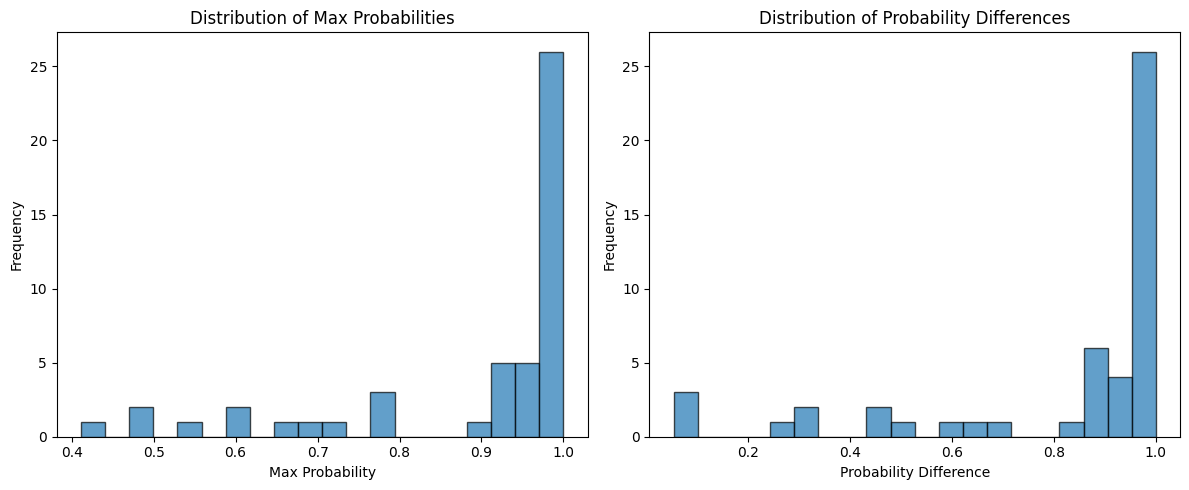

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First histogram (Max Probability)
axes[0].hist(y_pred_test_proba_max, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Max Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Max Probabilities')

# Second histogram (Difference between Top 2 Probabilities)
axes[1].hist(y_pred_test_proba_diff, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Probability Difference')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Probability Differences')

# Adjust layout
plt.tight_layout()
plt.show()

Now we add the functionality to predict the 5th class, the uncentain class

In [103]:
def predict_including_unknown(classifier, X, threshold=0.4, margin=0.2):
    """
    Predicts class labels for X, with an additional 'Unknown' class if:
    1. No class probability exceeds the threshold.
    2. The highest probability is not at least (1 + margin) times the second highest.
    
    :param classifier: A trained Naïve Bayes classifier with predict_proba().
    :param X: Input features.
    :param threshold: Minimum probability a class must exceed.
    :param margin: Minimum percentage difference between the top 2 classes.
    :return: Array of predicted labels, with 'Unknown' for uncertain predictions.
    """
    probas = classifier.predict_proba(X)  # Get probability estimates
    classes = classifier.classes_  # Get class labels
    predictions = []

    for probs in probas:
        max_prob = np.max(probs)
        sorted_probs = np.sort(probs)[::-1]  # Sort in descending order
        second_max_prob = sorted_probs[1] if len(sorted_probs) > 1 else 0

        # Check for uncertainty conditions
        if max_prob < threshold or max_prob < (1 + margin) * second_max_prob:
            predictions.append(5)
        else:
            predictions.append(classes[np.argmax(probs)])

    return np.array(predictions)

In [104]:
def filtered_accuracy(classifier, X_test, y_test, threshold=0.4, margin=0.2):
    """
    Computes accuracy on instances where a reliable prediction is made.

    :param classifier: A trained Naïve Bayes classifier with predict_proba().
    :param X_test: Test feature matrix.
    :param y_test: True labels for X_test.
    :param threshold: Minimum probability a class must exceed.
    :param margin: Minimum percentage difference between the top 2 classes.
    :return: Accuracy computed only on reliable predictions.
    """
    y_pred = predict_including_unknown(classifier, X_test, threshold, margin)
    
    # Filter out "Unknown" predictions
    mask = y_pred != 5
    filtered_y_pred = y_pred[mask]
    filtered_y_test = y_test[mask]
    
    # Compute accuracy only on valid predictions
    if len(filtered_y_test) == 0:
        return None  # Avoid division by zero, no reliable predictions made

    accuracy = np.mean(filtered_y_pred == filtered_y_test)
    return accuracy

In [107]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]
margins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

for threshold in thresholds:
    for margin in margins:
        y_pred_incl_unknown = predict_including_unknown(final_nb, X_test_final_model, threshold=threshold, margin=margin)
        unknown_count = sum(1 for x in y_pred_incl_unknown if x == 5)
        unknown_rate = unknown_count / len(y_pred_incl_unknown)
        accuracy = filtered_accuracy(final_nb, X_test_final_model, y_test_final_model, threshold=threshold, margin=margin)
        print(f"Threshold={threshold}, Margin={margin}: {unknown_rate * 100:.2f}% unknown & {accuracy * 100:.2f}% accurate")

Threshold=0.2, Margin=0.1: 0.00% unknown & 91.84% accurate
Threshold=0.2, Margin=0.15: 2.04% unknown & 91.67% accurate
Threshold=0.2, Margin=0.2: 4.08% unknown & 91.49% accurate
Threshold=0.2, Margin=0.25: 4.08% unknown & 91.49% accurate
Threshold=0.2, Margin=0.3: 6.12% unknown & 93.48% accurate
Threshold=0.2, Margin=0.35: 6.12% unknown & 93.48% accurate
Threshold=0.3, Margin=0.1: 0.00% unknown & 91.84% accurate
Threshold=0.3, Margin=0.15: 2.04% unknown & 91.67% accurate
Threshold=0.3, Margin=0.2: 4.08% unknown & 91.49% accurate
Threshold=0.3, Margin=0.25: 4.08% unknown & 91.49% accurate
Threshold=0.3, Margin=0.3: 6.12% unknown & 93.48% accurate
Threshold=0.3, Margin=0.35: 6.12% unknown & 93.48% accurate
Threshold=0.4, Margin=0.1: 0.00% unknown & 91.84% accurate
Threshold=0.4, Margin=0.15: 2.04% unknown & 91.67% accurate
Threshold=0.4, Margin=0.2: 4.08% unknown & 91.49% accurate
Threshold=0.4, Margin=0.25: 4.08% unknown & 91.49% accurate
Threshold=0.4, Margin=0.3: 6.12% unknown & 93.48

# Feature Importance

In [121]:
# Assuming final_nb is already trained
# Extract feature log probabilities
feature_probs = final_nb.feature_log_prob_

# Assuming you also have a fitted CountVectorizer
feature_names = final_nb_vectorizer.get_feature_names_out()

# Convert to DataFrame for better readability
feature_importance_df = pd.DataFrame(
    feature_probs.T,  # Transpose so features are rows
    index=feature_names,
    columns=[f"Class_{c}" for c in final_nb.classes_]
)

# Sort by importance for a specific class (e.g., Class_1)
feature_importance_df_sorted = feature_importance_df.sort_values(by="Class_1", ascending=False)

# Display top features per class
print(feature_importance_df_sorted.head(10))

             Class_0   Class_1    Class_2    Class_3
newline    -3.546234 -3.483929  -3.538235  -3.586221
bedrijf    -6.465093 -5.432861  -5.643931  -8.502575
europees   -8.432192 -5.733153  -7.041867  -7.874670
nederland  -5.916017 -5.742719  -6.460041  -7.269483
tata      -10.896467 -5.770852 -10.753952 -10.479549
industrie -10.896467 -5.815399 -10.753952 -10.479549
komen      -6.254255 -5.833063  -6.423120  -6.076283
land       -7.196824 -5.836295  -7.855445  -8.127617
steel     -10.896467 -5.842049 -10.753952 -10.479549
jaar       -5.613876 -5.876653  -5.397837  -5.728953


In [114]:
# Extract feature log probabilities
feature_probs = final_nb.feature_log_prob_

# Create a DataFrame with feature indices instead of names
feature_importance_df = pd.DataFrame(
    feature_probs.T,  # Transpose so features are rows
    index=range(feature_probs.shape[1]),  # Use feature indices as row labels
    columns=[f"Class_{c}" for c in final_nb.classes_]
)

# Sort by importance for a specific class (e.g., Class_1)
feature_importance_df_sorted = feature_importance_df.sort_values(by="Class_1", ascending=False)

# Display top 10 features per class
print(feature_importance_df_sorted.head(10))

        Class_0   Class_1    Class_2    Class_3
4085  -3.546234 -3.483929  -3.538235  -3.586221
814   -6.465093 -5.432861  -5.643931  -8.502575
2135  -8.432192 -5.733153  -7.041867  -7.874670
4039  -5.916017 -5.742719  -6.460041  -7.269483
5740 -10.896467 -5.770852 -10.753952 -10.479549
2929 -10.896467 -5.815399 -10.753952 -10.479549
3328  -6.254255 -5.833063  -6.423120  -6.076283
3452  -7.196824 -5.836295  -7.855445  -8.127617
5589 -10.896467 -5.842049 -10.753952 -10.479549
3119  -5.613876 -5.876653  -5.397837  -5.728953


In [116]:
feature_names = [f"Feature_{i}" for i in range(X_train_final_model.shape[1])]

In [117]:
feature_names

['Feature_0',
 'Feature_1',
 'Feature_2',
 'Feature_3',
 'Feature_4',
 'Feature_5',
 'Feature_6',
 'Feature_7',
 'Feature_8',
 'Feature_9',
 'Feature_10',
 'Feature_11',
 'Feature_12',
 'Feature_13',
 'Feature_14',
 'Feature_15',
 'Feature_16',
 'Feature_17',
 'Feature_18',
 'Feature_19',
 'Feature_20',
 'Feature_21',
 'Feature_22',
 'Feature_23',
 'Feature_24',
 'Feature_25',
 'Feature_26',
 'Feature_27',
 'Feature_28',
 'Feature_29',
 'Feature_30',
 'Feature_31',
 'Feature_32',
 'Feature_33',
 'Feature_34',
 'Feature_35',
 'Feature_36',
 'Feature_37',
 'Feature_38',
 'Feature_39',
 'Feature_40',
 'Feature_41',
 'Feature_42',
 'Feature_43',
 'Feature_44',
 'Feature_45',
 'Feature_46',
 'Feature_47',
 'Feature_48',
 'Feature_49',
 'Feature_50',
 'Feature_51',
 'Feature_52',
 'Feature_53',
 'Feature_54',
 'Feature_55',
 'Feature_56',
 'Feature_57',
 'Feature_58',
 'Feature_59',
 'Feature_60',
 'Feature_61',
 'Feature_62',
 'Feature_63',
 'Feature_64',
 'Feature_65',
 'Feature_66',
 'Fea

In [45]:
import PyPDF2
from sklearn.metrics.pairwise import cosine_similarity

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

# Function to recursively collect PDF file paths from subdirectories
def collect_pdf_files(folder_path):
    pdf_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pdf"):
                pdf_files.append(os.path.join(root, file))
    return pdf_files

# Function to clean the file path by removing everything before the first backslash
def clean_file_path(file_path):
    # Extract everything after the first backslash
    parts = file_path.split("\\", 1)
    return parts[-1] if len(parts) > 1 else file_path

# Path to your 'full classification dataset' folder
folder_path = "full classification dataset"

# Collect all PDF files in the folder and its subfolders
pdf_files = collect_pdf_files(folder_path)

# Extract text from all PDFs and create a DataFrame
article_texts = []
for i, pdf_file in enumerate(pdf_files):
    text = extract_text_from_pdf(pdf_file)
    article_texts.append({
        "article_id": f"article_{i + 1}",
        "text": text,
        "file_path": pdf_file  # Add file path to each article
    })

# Convert to a DataFrame named df_duplicate_test
df_duplicate_test = pd.DataFrame(article_texts)

# Convert article texts into a TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_duplicate_test["text"])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Convert to DataFrame for better readability
cosine_df = pd.DataFrame(cosine_sim, index=df_duplicate_test["article_id"], columns=df_duplicate_test["article_id"])

# Find pairs with similarity > 0.99 (excluding self-similarity)
similar_articles = []
threshold = 0.99

for i, id1 in enumerate(df_duplicate_test["article_id"]):
    for j, id2 in enumerate(df_duplicate_test["article_id"]):
        if i < j and cosine_df.loc[id1, id2] > threshold:
            # Retrieve the file paths for the two similar articles and clean them
            file_path_1 = clean_file_path(df_duplicate_test.loc[df_duplicate_test["article_id"] == id1, "file_path"].values[0])
            file_path_2 = clean_file_path(df_duplicate_test.loc[df_duplicate_test["article_id"] == id2, "file_path"].values[0])
            similar_articles.append((file_path_1, file_path_2, cosine_df.loc[id1, id2]))

# Create a DataFrame to store the results
similar_articles_df = pd.DataFrame(similar_articles, columns=["file_1", "file_2", "similarity"])

# Display the results
similar_articles_df

,file_1,file_2,similarity
0,"Bouw & Vastgoed\10, 22-10-2024.pdf","Zorg\12, 22-10-2024.pdf",0.994780
1,"Bouw & Vastgoed\15, 29-10-2024.pdf","Handel & Industrie\20, 29-10-2024.pdf",1.000000
2,"Bouw & Vastgoed\20, 19-11-2024.pdf","Zorg\15, 19-11-2024.pdf",1.000000
3,"Bouw & Vastgoed\26, 04-12-2024.pdf","Handel & Industrie\33, 04-12-2024.pdf",1.000000
4,"Bouw & Vastgoed\26, 04-12-2024.pdf","Zakelijke Dienstverlening\33, 04-12-2024.pdf",1.000000
5,"Bouw & Vastgoed\26, 04-12-2024.pdf","Zorg\17, 04-12-2024.pdf",1.000000
6,"Bouw & Vastgoed\33, 23-01-2025.pdf","Handel & Industrie\43, 23-01-2025.pdf",1.000000
7,"Bouw & Vastgoed\8, 22-10-2024.pdf","Zakelijke Dienstverlening\17, 22-10-2024.pdf",0.997587
8,"Handel & Industrie\15, 21-10-2024.pdf","Zorg\11, 21-10-2024.pdf",1.000000
9,"Handel & Industrie\25, 14-11-2024.pdf","Zakelijke Dienstverlening\25, 14-11-2024.pdf",1.000000


In [47]:
import PyPDF2
from sklearn.metrics.pairwise import cosine_similarity

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

# Function to recursively collect PDF file paths from subdirectories
def collect_pdf_files(folder_path):
    pdf_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pdf"):
                pdf_files.append(os.path.join(root, file))
    return pdf_files

# Function to clean the file path by removing everything before the first backslash
def clean_file_path(file_path):
    # Extract everything after the first backslash
    parts = file_path.split("\\", 1)
    return parts[-1] if len(parts) > 1 else file_path

# Path to your 'full classification dataset' folder
folder_path = "data including duplicates (as backup)"

# Collect all PDF files in the folder and its subfolders
pdf_files = collect_pdf_files(folder_path)

# Extract text from all PDFs and create a DataFrame
article_texts = []
for i, pdf_file in enumerate(pdf_files):
    text = extract_text_from_pdf(pdf_file)
    article_texts.append({
        "article_id": f"article_{i + 1}",
        "text": text,
        "file_path": pdf_file  # Add file path to each article
    })

# Convert to a DataFrame named df_duplicate_test
df_duplicate_test = pd.DataFrame(article_texts)

# Convert article texts into a TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_duplicate_test["text"])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Convert to DataFrame for better readability
cosine_df = pd.DataFrame(cosine_sim, index=df_duplicate_test["article_id"], columns=df_duplicate_test["article_id"])

# Find pairs with similarity > 0.99 (excluding self-similarity)
similar_articles = []
threshold = 0.99

for i, id1 in enumerate(df_duplicate_test["article_id"]):
    for j, id2 in enumerate(df_duplicate_test["article_id"]):
        if i < j and cosine_df.loc[id1, id2] > threshold:
            # Retrieve the file paths for the two similar articles and clean them
            file_path_1 = clean_file_path(df_duplicate_test.loc[df_duplicate_test["article_id"] == id1, "file_path"].values[0])
            file_path_2 = clean_file_path(df_duplicate_test.loc[df_duplicate_test["article_id"] == id2, "file_path"].values[0])
            similar_articles.append((file_path_1, file_path_2, cosine_df.loc[id1, id2]))

# Create a DataFrame to store the results
similar_articles_df = pd.DataFrame(similar_articles, columns=["file_1", "file_2", "similarity"])

# Display the results
similar_articles_df

,file_1,file_2,similarity
0,"Bouw & Vastgoed\10, 22-10-2024.pdf","Zorg\12, 22-10-2024.pdf",0.994830
1,"Bouw & Vastgoed\15, 29-10-2024.pdf","Handel & Industrie\20, 29-10-2024.pdf",1.000000
2,"Bouw & Vastgoed\20, 19-11-2024.pdf","Zorg\15, 19-11-2024.pdf",1.000000
3,"Bouw & Vastgoed\26, 04-12-2024.pdf","Handel & Industrie\33, 04-12-2024.pdf",1.000000
4,"Bouw & Vastgoed\26, 04-12-2024.pdf","Zakelijke Dienstverlening\33, 04-12-2024.pdf",1.000000
5,"Bouw & Vastgoed\26, 04-12-2024.pdf","Zorg\17, 04-12-2024.pdf",1.000000
6,"Bouw & Vastgoed\8, 22-10-2024.pdf","Zakelijke Dienstverlening\17, 22-10-2024.pdf",0.997662
7,"Handel & Industrie\15, 21-10-2024.pdf","Zorg\11, 21-10-2024.pdf",1.000000
8,"Handel & Industrie\25, 14-11-2024.pdf","Zakelijke Dienstverlening\25, 14-11-2024.pdf",1.000000
9,"Handel & Industrie\28, 27-11-2024.pdf","Zakelijke Dienstverlening\29, 27-11-2024.pdf",0.995958


The following choices were made: <br>
> - Row 0: 
> - Row 1: 